Tutorial on "Bayes-by-Backprop" (BBB) a Bayesian Neural Network using Variational Inference 
===

**Papers:**
- [Weight Uncertainty in Neural Networks.](https://arxiv.org/abs/1505.05424) Charles Blundell, Julien Cornebise, Koray Kavukcuoglu, Daan Wierstra.
- [Reliable Uncertainty Estimates in Deep Neural Networks using Noise Contrastive Priors](https://arxiv.org/abs/1807.09289). Danijar Hafner, Dustin Tran, Timothy Lillicrap, Alex Irpan, James Davidson.

**Collaborators:** Shyana Stein | Emma Krause | Stephen Holtz | Chong Guo

**Repository:** https://github.com/chongguo/ADVI-pymc3-Fashion-MNIST

**Why BBB?** Neural networks are able to model extremely complex problems and generate accurate predictions. Nevertheless, in many real world applications we want a prediction and the confidence associated with that prediction. BBB accomplishes this by doing a varitional approximation to a full Bayesian inference on the networks weights. At inference time, the weights can simply be sampled to generate a post-predictive distribution from which the confidence of the prediction can be infered. 

# Outline:
 1. **Deriving the Update Rule for BBB**
 2. **Bayes by Backprop by Hand** (implementation compared to SGD)
 2. **BBB for Classification** (Fashion-MNIST)
 3. **Extending BBB Using Noise Contrastive Priors**
 4. **BBB for Active Learning**

Note: for parts 4 and 5 of the outline, we have pickled the time intensive parts of the notebook. Simply change the `load_pickle` flags to `False` if you want to re-run these parts. Non-pickled parts of the notebook should only take ~16 mins to run in total on a modern laptop (e.g. 2016 MacBook Pro). Most functions and for-loops that take substantial time are wrapped by dynamic print statements using the `tqdm` library or similar. To generate an environment to run this notebook, see the repository listed above for instructions.

# 1. Deriving the Update Rule for BBB

$$
\DeclareMathOperator*{\argmin}{argmin}
$$

BBB view a neural network as a probablistic model $p(D,w)$. The parameters are typically estimated using MLE by maximizing $p(D|w)$ or MAP, which uses a prior $p(w)$ to regularize the weights. The full Bayesian treatment would be prohibitively expensive if not intractable in many cases. Thus as others have previously suggested, a mean-field variational approximation to $p(w|D)$ is used instead by minimizing the KL divergence between the two distributions as shown below:

$$
\begin{align}
\theta^* &= \argmin_{\theta} KL[q(w|\theta)||p(w|D)] \\
&=\argmin_{\theta} \int q(w|\theta) log\frac{q(w|\theta)}{p(w)p(D|w)}dw\\
&=\argmin_{\theta} \int \big\{log\ q(w|\theta)-log\ p(w) - log\ p(D|w)\big\} q(w|\theta) dw
\end{align}
$$

This expectation can be approximated via monte carlo samples. Moreover, using the reparametrization tricks we can evaluate the gradient w.r.t. to $\theta$ at the $(i)$th monte carlo sample of the cost function. All together we can summarize this optimization process as follows:

1. sample $\epsilon ~ N(0,I)$
2. Let $w = \mu + log(1+exp(\rho))\circ \epsilon$ 
   (note: $\circ$ - Hadamard product)
3. Let $\theta = (\mu,\rho)$
4. Let $f(w|\theta) = log\ q(w|\theta)-log\ p(w) - log\ p(D|w)$
5. Calculate the gradient w.r.t. the mean and deviation parameters:
$$
\begin{align}
\Delta_\mu &= \frac{\partial f(w|\theta)}{\partial w} + \frac{\partial f(w|\theta)}{\partial\mu}\\
\Delta_\rho &= \frac{\partial f(w|\theta)}{\partial w}\frac{\epsilon}{1+exp(-\rho)} + \frac{\partial f(w|\theta)}{\partial\rho}
\end{align}
$$
6. Update the variational parameters:
$$
\begin{align}
    \mu &\leftarrow \mu -\alpha\Delta_\mu \\
    \rho &\leftarrow \rho -\alpha\Delta_\rho
\end{align}
$$
where $\alpha$ is the learning rate

Noting that $\frac{\partial f(w|\theta)}{\partial w}$ is the normal gradient descent update for $w$ we decide to use a simple regression problem to illustrate the operation of BBB. 

# 2. Bayes by Backprop by Hand

BBB views a neural network as a probablistic model $p(D,w)$. The parameters are typically estimated using MLE by maximizing $p(D|w)$ or MAP, which uses a prior $p(w)$ to regularize the weights.

In [1]:
import sys,time
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

import pandas as pd
import numpy as np
import scipy as sp

import pymc3 as pm
import theano
import theano.tensor as tt
import tensorflow as tf

from tqdm import tqdm
from collections import OrderedDict
from warnings import filterwarnings

In [2]:
# Print environment for consistency
print('Environment: ', sys.executable)
# Print versions
print('PyMC3  v{} | Theano v{} | Tensorflow v{}'.format(pm.__version__,theano.__version__,tf.__version__))
# Fix plotting
mpl.rcdefaults()
%matplotlib inline
# Set random seeds
np.random.seed(999)
pm.set_tt_rng(999)
# Avoid warnings on batches below
filterwarnings('ignore')

Environment:  /Users/stephenholtz/anaconda3/envs/bbb_models/bin/python
PyMC3  v3.5 | Theano v1.0.3 | Tensorflow v1.10.0


First we construct a toy regression problem that highlights some of the benefits of using a bayesian neural network to fit data. The task is to fit the polynomial (plotted as $\mu_y$, below) which was both sampled unevenly _and_ is heteroscedastic. The latter feature comes from the `sig_y_func` `lambda` function below, plotted as $\sigma_y$.

In [3]:
# Define toy regression problem parameters and generate the data
m_mu,m_sig = (0.2,-1)
mu_y_func = lambda x,m: np.sin(x*1.5) + np.dot(x,m)
sig_y_func = lambda x,m: 0.25*np.log(1+np.exp(np.dot(x,m)))

def generate_regression_data():
    Sig_x_mix = [0.8,0.5]  #[2,.5]
    Mu_x_mix = [-1.7,2]  #[-2.5,2]
    p_x = 0.6  # probability of cluster 1
    n_x = 1000 # number of samples in x
    # randomly generate cluster identity
    n_x_id = np.random.binomial(n_x,p_x) 
    n_x_id = [n_x_id,n_x-n_x_id]
    # sample x from a gaussian mixture
    x0 = np.random.randn(n_x_id[0],1)*Sig_x_mix[0]+Mu_x_mix[0]
    x1 = np.random.randn(n_x_id[1],1)*Sig_x_mix[1]+Mu_x_mix[1]
    x = np.concatenate((x0,x1))
    
    y_mu = mu_y_func(x,m_mu)
    y_sig = sig_y_func(x,m_sig)
    y = y_mu + np.random.randn(n_x,1)*y_sig
    
    ridx = np.random.choice(range(n_x),n_x)
    x = x[ridx,:]
    y = y[ridx,:]
    y_mu = y_mu[ridx,:]
    y_sig = y_sig[ridx,:]
    
    return x,y,y_mu,y_sig
x,y,y_mu,y_sig = generate_regression_data()

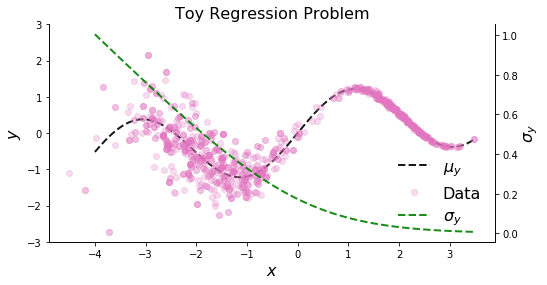

In [4]:
figsize = (8,4); fontsize = 16;
f, ax = plt.subplots(1, 1, figsize=figsize, sharex=True, sharey=True);

xs = np.linspace(-4,3.5,num=1000)
plt1,=ax.plot(xs,mu_y_func(xs,m_mu),color='k',linestyle='--',linewidth=2,alpha=0.9,label=r'$\mu_y$')
plt2,=ax.plot(x,y,'o',alpha=0.25,color='C6',label='Data')
ax.set_xlabel("$x$",fontsize=fontsize)
ax.set_ylabel("$y$",fontsize=fontsize)
ax.set_title("Toy Regression Problem",fontsize=fontsize)
ax.set_ylim(bottom=-3,top=3)

axy2 = ax.twinx()
plt3,=axy2.plot(xs,sig_y_func(xs,m_sig),color='g',linestyle='--',linewidth=2,alpha=0.9,label=r'$\sigma_y$')
axy2.set_ylabel(r'$\sigma_y$',fontsize=fontsize)
ax.legend(handles=[plt1,plt2,plt3],frameon=False,fontsize=fontsize);
ax.spines['top'].set_visible(False); axy2.spines['top'].set_visible(False)

We will use a MLP with a single non-linear (hyperbolic tangent) hidden layer and a linear output to fit this data. First we demonstrate using normal gradient descent with the `MLP` class defined below. It implements methods for both `forward` and `backwards` (backprop) runs through the network, and keeps track of all weights and gradients as object properties. Additionally, we implement a `predict` method to check performance on test data.

In [5]:
# a linear function
g_ = lambda x,m,b: np.dot(x,m) + b
# a tanh function 
f_ = lambda g: np.tanh(g)
# derivatave of tanh function
dfdg_ = lambda g: 1.0 - np.tanh(g)**2

# now we define a simple MLP with one input n hidden and one output
class MLP():
    def __init__(self,nhidden,nbatch,alpha):
        self.nhidden = nhidden
        self.alpha = alpha
        # weight prior sigma
        self.w1_sig,self.b1_sig,self.w2_sig,self.b2_sig = (1,1,1,1)

        # weight initialization
        self.w1 = np.random.randn(1,nhidden)
        self.b1 = np.random.randn(1,nhidden)
        self.w2 = np.random.randn(nhidden,1)
        self.b2 = np.random.randn(1,1)
        
        self.x = np.zeros((nbatch,1))
        self.z = np.zeros((nbatch,nhidden))
        self.h = np.zeros((nbatch,nhidden))
        self.y = np.zeros((nbatch,1))
        
    def forward(self,x):
        self.x = x
        self.z = g_(self.x,self.w1,self.b1)
        self.h = f_(self.z)
        self.y = g_(self.h,self.w2,self.b2)
        return self.y
    
    def predict(self,x):
        z = g_(x,self.w1,self.b1)
        h = f_(z)
        y = g_(h,self.w2,self.b2)
        return y
        
    def backward(self,y_target):
        dy = self.y-y_target
        dw2 = np.dot(dy.T,self.h).T
        db2 = np.sum(dy,0)
        dz = np.outer(dy,self.w2.T)*dfdg_(self.z)
        dw1 = np.dot(dz.T,self.x).T
        db1 = np.sum(dz,0)
        
        self.w1 += -self.alpha*(dw1+self.w1/self.w1_sig)
        self.b1 += -self.alpha*(db1+self.b1/self.b1_sig)
        self.w2 += -self.alpha*(dw2+self.w2/self.w2_sig)
        self.b2 += -self.alpha*(db2+self.b2/self.b2_sig)
        
        err = np.sum(dy**2)
        return err

# Now we run the MLP and keep track of the error
net_GD = MLP(20,x.shape[0],1e-4)
nepoch = 10000
err_gd = np.zeros((nepoch,1))
for i in tqdm(range(nepoch)):
    net_GD.forward(x)
    err_gd[i] = net_GD.backward(y)

x_grid = np.linspace(np.min(x),np.max(x),1000).reshape((1000,-1))
y_pred = net_GD.predict(x_grid)

100%|██████████| 10000/10000 [00:05<00:00, 1733.75it/s]


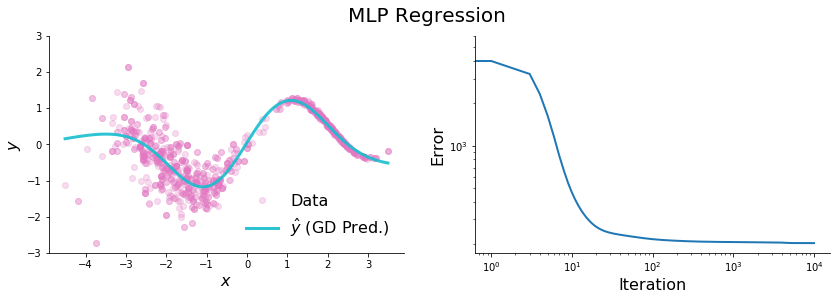

In [6]:
# plot the gradient descent output
figsize = (14,4); fontsize = 16;
f, axs = plt.subplots(1, 2, figsize=figsize);

ax = axs[0]
xs = np.linspace(-4,3.5,num=1000)

plt1,=ax.plot(x,y,'o',alpha=0.25,color='C6',label='Data')
plt2,=ax.plot(x_grid,y_pred,linewidth=3,color='C9',alpha=0.9,label=r'$\hat{y}$ (GD Pred.)')
ax.set_xlabel("$x$",fontsize=fontsize)
ax.set_ylabel("$y$",fontsize=fontsize)
ax.set_ylim(bottom=-3,top=3)
ax.legend(frameon=False,fontsize=fontsize);
sns.despine();

ax = axs[1]
ax.plot(err_gd,linewidth=2,color='C0')
ax.set_xlabel("Iteration",fontsize=fontsize)
ax.set_ylabel("Error",fontsize=fontsize)
ax.set_yscale('log')
ax.set_xscale('log')
ax.spines['top'].set_visible(False); 
ax.spines['right'].set_visible(False);

f.suptitle("MLP Regression",fontsize=fontsize+4);

This looks good. Error decreases with iteration, and we end up with a prediction from gradient descent that fits the central cloud of the datapoints. However, we do not have any notion of uncertainty. To remedy this, we now construct a BBB network that has the same basic structure.

In [7]:
sr = lambda x: np.log(1+np.exp(x))+1e-8
dsr = lambda x: 1/(1+np.exp(-x))+1e-8

class MLP_BBB():
    def __init__(self,nhidden,nbatch,alpha):
        self.nhidden = nhidden
        self.alpha = alpha
        # weight prior sigma
        self.w1_mu_sig = 1;
        self.b1_mu_sig = 1;
        self.w2_mu_sig = 1;
        self.b2_mu_sig = 1;
        self.w1_pi_sig = 1;
        self.b1_pi_sig = 1;
        self.w2_pi_sig = 1;
        self.b2_pi_sig = 1;
        # initialize the parameters both in terms of mu and sigma
        self.w1_mu = np.random.randn(1,nhidden)
        self.b1_mu = np.random.randn(1,nhidden)
        self.w2_mu = np.random.randn(nhidden,1)
        self.b2_mu = np.random.randn(1,1)
        self.w1_pi = np.random.randn(1,nhidden)
        self.b1_pi = np.random.randn(1,nhidden)
        self.w2_pi = np.random.randn(nhidden,1)
        self.b2_pi = np.random.randn(1,1)
        
        self.w1 = np.random.randn(1,nhidden)
        self.b1 = np.random.randn(1,nhidden)
        self.w2 = np.random.randn(nhidden,1)
        self.b2 = np.random.randn(1,1)
        
        self.w1_e = np.random.randn(1,nhidden)
        self.b1_e = np.random.randn(1,nhidden)
        self.w2_e = np.random.randn(nhidden,1)
        self.b2_e = np.random.randn(1,1)
        
        self.x = np.zeros((nbatch,1))
        self.z = np.zeros((nbatch,nhidden))
        self.h = np.zeros((nbatch,nhidden))
        self.y = np.zeros((nbatch,1))
        
    def forward(self,x):
        self.w1_e = np.random.randn(1,self.nhidden)
        self.b1_e = np.random.randn(1,self.nhidden)
        self.w2_e = np.random.randn(self.nhidden,1)
        self.b2_e = np.random.randn(1,1)
        self.w1 = self.w1_e*sr(self.w1_pi) + self.w1_mu
        self.b1 = self.b1_e*sr(self.b1_pi) + self.b1_mu
        self.w2 = self.w2_e*sr(self.w2_pi) + self.w2_mu
        self.b2 = self.b2_e*sr(self.b2_pi) + self.b2_mu
        
        self.x = x
        self.z = g_(self.x,self.w1,self.b1)
        self.h = f_(self.z)
        self.y = g_(self.h,self.w2,self.b2)
        return self.y
    
    def predict(self,x):
        self.w1 = self.w1_mu
        self.b1 = self.b1_mu
        self.w2 = self.w2_mu
        self.b2 = self.b2_mu
        
        self.x = x
        self.z = g_(self.x,self.w1,self.b1)
        self.h = f_(self.z)
        self.y = g_(self.h,self.w2,self.b2)
        return self.y
    
    def confidence(self,x,nsim):
        y_sim = np.zeros((x.shape[0],nsim))
        for i in range(nsim):
            y_sim[:,i] = self.forward(x)[:,0]
        y_std = np.std(y_sim,1).reshape([x.shape[0],-1])
        return y_sim, y_std
    
    def backward(self,y_target):
        dy = self.y-y_target
        dw2 = np.dot(dy.T,self.h).T
        db2 = np.sum(dy,0)
        dz = np.outer(dy,self.w2.T)*dfdg_(self.z)
        dw1 = np.dot(dz.T,self.x).T
        db1 = np.sum(dz,0)
        
        self.w1_mu += -self.alpha*(dw1+self.w1_mu/self.w1_mu_sig+self.w1_e/sr(self.w1_pi))
        self.b1_mu += -self.alpha*(db1+self.b1_mu/self.b1_mu_sig+self.b1_e/sr(self.b1_pi))
        self.w2_mu += -self.alpha*(dw2+self.w2_mu/self.w2_mu_sig+self.w2_e/sr(self.w2_pi))
        self.b2_mu += -self.alpha*(db2+self.b2_mu/self.b2_mu_sig+self.b2_e/sr(self.b2_pi))
        self.w1_pi += -self.alpha*((dw1+self.w1_pi/self.w1_pi_sig)*dsr(self.w1_pi)*self.w1_e+(self.w1_e**2-1)/sr(self.w1_pi)*dsr(self.w1_pi))
        self.b1_pi += -self.alpha*((db1+self.b1_pi/self.b1_pi_sig)*dsr(self.b1_pi)*self.b1_e+(self.b1_e**2-1)/sr(self.b1_pi)*dsr(self.b1_pi))
        self.w2_pi += -self.alpha*((dw2+self.w2_pi/self.w2_pi_sig)*dsr(self.w2_pi)*self.w2_e+(self.w2_e**2-1)/sr(self.w2_pi)*dsr(self.w2_pi))
        self.b2_pi += -self.alpha*((db2+self.b2_pi/self.b2_pi_sig)*dsr(self.b2_pi)*self.b2_e+(self.b2_e**2-1)/sr(self.b2_pi)*dsr(self.b2_pi))
        
        err = np.sum(dy**2)
        return err

In [8]:
net_BBB = MLP_BBB(20,x.shape[0],5e-5)
nepoch = 100000
err_BBB = np.zeros((nepoch,1))
for i in tqdm(range(nepoch)):
    net_BBB.forward(x)
    err_BBB[i] = net_BBB.backward(y)

x_grid = np.linspace(np.min(x),np.max(x),1000).reshape((1000,-1))
y_pred = net_BBB.predict(x_grid)
y_ppc,y_std = net_BBB.confidence(x_grid,100)

100%|██████████| 100000/100000 [01:26<00:00, 1156.94it/s]


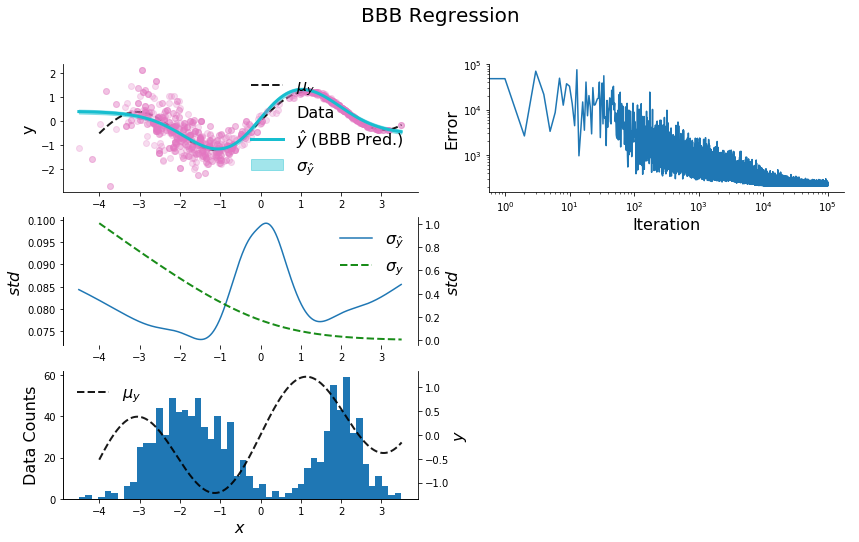

In [9]:
# plot the gradient descent output
figsize = (14,8); fontsize = 16;
f, axs = plt.subplots(3, 2, figsize=figsize);
xs = np.linspace(-4,3.5,num=1000)

ax = axs[0,0]
ax.plot(xs,mu_y_func(xs,m_mu),color='k',linestyle='--',linewidth=2,alpha=0.9,label=r'$\mu_y$')
ax.plot(x,y,'o',alpha=0.25,color='C6',label='Data')
ax.plot(x_grid,y_pred,color='C9',linewidth=3,label=r'$\hat{y}$ (BBB Pred.)')
ax.fill_between(x_grid.flatten(),(y_pred+y_std).flatten(),(y_pred-y_std).flatten(),
                color='C9', alpha=0.4, label=r'$\sigma_{\hat{y}}$ ')
ax.set_xlabel("x",fontsize=fontsize); ax.set_ylabel("y",fontsize=fontsize)
ax.legend(frameon=False,fontsize=fontsize); sns.despine();

ax = axs[0,1]
ax.plot(err_BBB)
ax.set_xlabel("Iteration",fontsize=fontsize); ax.set_ylabel("Error",fontsize=fontsize)
ax.set_yscale('log');ax.set_xscale('log'); sns.despine();

ax = axs[1,0]
plt1, = ax.plot(x_grid,y_std,label=r'$\sigma_{\hat{y}}$');
ax.set_ylabel("$std$",fontsize=fontsize)
axy2 = ax.twinx()
plt2, = axy2.plot(xs,sig_y_func(xs,m_sig),color='g',linestyle='--',linewidth=2,alpha=0.9,label=r'$\sigma_y$')
axy2.set_ylabel("$std$",fontsize=fontsize)
axy2.legend(handles=[plt1,plt2],frameon=False,fontsize=fontsize);
ax.spines['top'].set_visible(False); axy2.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False); axy2.spines['bottom'].set_visible(False)

ax = axs[2,0]
ax.hist(x,50);
ax.set_xlabel("$x$",fontsize=fontsize)
ax.set_ylabel("Data Counts",fontsize=fontsize)
ax.spines['top'].set_visible(False); axy2.spines['top'].set_visible(False)

axy2 = ax.twinx()
axy2.plot(xs,mu_y_func(xs,m_mu),color='k',linestyle='--',linewidth=2,alpha=0.9,label=r'$\mu_y$')
axy2.set_ylabel("$y$",fontsize=fontsize)
axy2.legend(frameon=False,fontsize=fontsize);
ax.spines['top'].set_visible(False); axy2.spines['top'].set_visible(False)
ax = axs[1,1];ax.axis('off'); ax = axs[2,1]; ax.axis('off');

f.suptitle("BBB Regression",fontsize=fontsize+4);

Just like in the gradient descent expample above, this network shows decreasing error with iteration, and a prediction that hugs the midline of the data nicely. Now, we can additionally inspect the uncertainty by plotting it on top. We zoom in on this and superimpose both the varying variance $\sigma_y$ and show histograms with datapoint counts. In this case it appears that the dominant effect on the variance in the model comes from differences in number of datapoints. In other words, the areas of the histogram with high counts correspond to the same bins of $x$ values where the predictions of the model vary ($\sigma_{\hat{y}}$) less.

# 3. BBB for Classification

Now we construct a simple one layer bayesian network using ADVI for approximate inference in PyMC3 to classify the Fashion-MNIST images. Then, we look at performance metrics and use the inherently probabilistic nature of this model to look at performance variance. We also loosely compare to a similarly designed traditional neural network made with SGD using tensorflow via Keras. 

## Import the dataset 

First we will use keras to load in the Fashion-MNIST data, and preprocess it for easy use. Note we avoid making the `X_train`, `X_test` etc. into a theano shared variable here so that we can use it for our tensorflow network as well.

In [10]:
def load_fashionMNIST():
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    X_train = X_train.astype(theano.config.floatX,copy=True).reshape(X_train.shape[0],-1)/255
    X_test = X_test.astype(theano.config.floatX,copy=True).reshape(X_test.shape[0],-1)/255
    y_train, y_test = y_train.astype(np.int), y_test.astype(np.int)
    return (X_train,y_train),(X_test,y_test)
# Fashion-MNIST labels
label_dict = OrderedDict({0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover',
                          3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt',
                          7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'})
(X_train, y_train), (X_test, y_test) = load_fashionMNIST()
imgvec2img = lambda vec : vec.reshape(np.sqrt(vec.shape[0]).astype(int),-1)

The data are similar to MNIST in size, but instead of handwritten numbers, consist of shirts, shoes etc., Below we look a random subset of them.

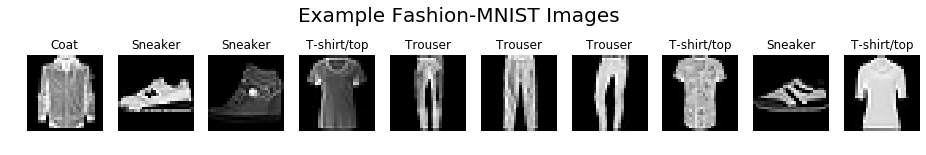

In [11]:
n_plot_samples = 10
rand_samps = np.random.choice(X_train.shape[0],size=n_plot_samples,replace=False)
figsize = (16,2.5); fontsize = 16;
f, axs = plt.subplots(1,n_plot_samples,sharex=True,figsize=figsize);
for rs,ax in zip(rand_samps,axs):
    ax.imshow(imgvec2img(X_train[rs]),cmap='gray');
    ax.axis('off')
    ax.set_title(label_dict[y_train[rs]]);
    sns.despine();
f.suptitle("Example Fashion-MNIST Images",fontsize=fontsize+4);

## Make and Train a Single Hidden Layer Network Backprop with SGD
Just like in the previous section, we will look at a traditional neural network trained using gradient descent. In this case we will  we will use tensorflow (via keras) to make a network with the same architecture as our soon to be implemented bayesian neural network (below). This will serve as a comparison point just as the hand-built network above did, except this time, we let an ML library do the heavy lifting for us. Note this will not exactly be a fair fight, but we will train similar amounts, and for qualitative and didactic comparison purposes this is fine.

Generating the one layer network and training on the data with keras is straighforward. Here we opt to convert the categorical indexes to "one hot" encodings to avoid errors later on.

In [12]:
# We selected number of nodes in the hidden layer for fast performance
n_hidden = 96
n_output = len(label_dict)

# make more convenient categorical variables for keras
y_train_onehot = tf.keras.utils.to_categorical(y_train,num_classes=n_output)
y_test_onehot = tf.keras.utils.to_categorical(y_test,num_classes=n_output)

def make_1layer_tf_network(n_input,n_output,n_hidden):
    from tensorflow.keras.models import Sequential, Model
    from tensorflow.keras.layers import Dense, Input

    ann_input = Input(shape=(n_input,))
    x = Dense(n_hidden, activation='tanh')(ann_input)
    x = Dense(n_output, activation='softmax')(x)
    tf_model = Model(ann_input,x)
    tf_model.compile(optimizer='sgd',loss='sparse_categorical_crossentropy',metrics=['accuracy']);
    return tf_model

tf_model = make_1layer_tf_network(np.prod(X_train.shape[1:]),len(label_dict),n_hidden)
tf_model.fit(X_train, y_train, epochs=5, batch_size=50, verbose=0); # Silence output for sanity

In [13]:
tf_train_preds = tf_model.predict(X_train, batch_size=50)
tf_test_preds = tf_model.predict(X_test, batch_size=50)

tf_train_loss, tf_train_acc = tf_model.evaluate(X_train, y_train)
tf_test_loss, tf_test_acc = tf_model.evaluate(X_test, y_test)

print("SGD Network Accuracy\nTrain: {:f} Test: {:f}".format(tf_train_acc,tf_test_acc))

10000/10000 [==============================] - 0s 10us/step
SGD Network Accuracy
Train: 0.842800 Test: 0.829200


The network does pretty well after a small number of epochs, surpassing 80% accuraracy on both training and the held-out test datasets. To get an idea of the performance and types of errors, we can plot a random subset of the test data to look for errors and correct predictions.

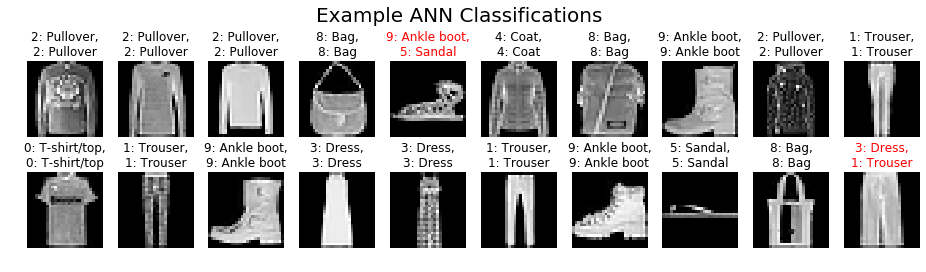

In [14]:
n_plot_samples = (10,2)
rand_samps = np.random.choice(X_test.shape[0],size=n_plot_samples)

figsize = (16,3.75); fontsize = 16;
f, axs = plt.subplots(n_plot_samples[1],n_plot_samples[0], figsize=figsize);

for i,(rst,axt) in enumerate(zip(rand_samps,axs.T)):
    for j,(rs,ax) in enumerate(zip(rst,axt)):
        pred = np.argmax(tf_test_preds[rs])
        real = y_test[rs]
        ax.imshow(imgvec2img(X_test[rs]),cmap='gray');
        tl = "{}: {},\n{}: {}".format(pred,label_dict[pred],real,label_dict[real])
        if pred == real:
            ax.set_title(tl,color='k');
        else:
            ax.set_title(tl,color='r');
        ax.axis('off');
f.suptitle("Example ANN Classifications",fontsize=fontsize+4,y=1.05);

We see the types of errors are "understandable" things that seem pretty similar in outline are often misclassified, such as shirts with pullovers, coats with dresses, and ankle boots with sneakers. This is informative, but just as before we don't have any principled way to estimate of the confidence of any given prediction from the network. As in the previous section, we will turn to a BBB network to remedy this situation.

## Build and fit the BBB model
Now we construct a single layer bayesian neural network with all weights using a composite normal distribution as in the Bayes by BackProp paper. In this case we make use of the elegant `pymc3` library to explicitly construct prior distributions on all the weights, as well as functions between the layers. Below is a function `make_1layer_bbb_network` which will construct a BBB network as in the original paper, modulo details that were left unspecified. For example, the authors of the original BBB paper use a prior that is two gaussians weighted by  a parameter `pi`. We chose our value fpr `pi` roughly to be able to see model convergence and to achieve reasonable model performance. Ditto the standard deviations for the two gaussians that comprise the composite. Note we found small changes to these values were not critical for achieving similar classification performance. 

In [15]:
def make_1layer_bbb_network(ann_input, ann_output, n_input, n_output, n_train, n_hidden=64, use_bias=True, allow_minibatch=True):
     # initial weights, standard normal here and scaled below to match prior distributions
    init_w_in_1 = np.random.randn(n_input, n_hidden).astype(theano.config.floatX)
    init_b_1 = np.random.randn(n_hidden).astype(theano.config.floatX)
    init_w_1_out = np.random.randn(n_hidden, n_output).astype(theano.config.floatX)
    
    pi  = 0.95 # weighting between normals
    sda = 1.75 # sd for first normal
    sdb = 0.25 # sd for second normal
    
    with pm.Model() as neural_network:
        # Weights from input to first hidden layer
        w_in_1a = pm.Normal('w_in_1a', mu=0, sd=sda, shape=(n_input, n_hidden),testval=init_w_in_1*sda)
        w_in_1b = pm.Normal('w_in_1b', mu=0, sd=sdb, shape=(n_input, n_hidden),testval=init_w_in_1*sdb)
        w_in_1 = pm.Deterministic('w_in_1',pi*w_in_1a+(1-pi)*w_in_1b)
        # Bias in first layer        
        if use_bias:
            b_1a = pm.Normal('b_1a',mu=0, sd=sda, shape=(n_hidden),testval=init_b_1*sda)
            b_1b = pm.Normal('b_1b',mu=0, sd=sdb, shape=(n_hidden),testval=init_b_1*sdb)
            b_1 = pm.Deterministic('b_1',pi*b_1a+(1-pi)*b_1b)
        else:
            b_1 = 0
        
        # Weights from 1st hidden layer to output layer
        w_1_outa = pm.Normal('w_1_outa',mu=0, sd=sda, shape=(n_hidden, n_output),testval=init_w_1_out*sda)
        w_1_outb = pm.Normal('w_1_outb',mu=0, sd=sdb, shape=(n_hidden, n_output),testval=init_w_1_out*sdb)
        w_1_out = pm.Deterministic('w_1_out',pi*w_1_outa+(1-pi)*w_1_outb)
        
        # Build neural-network using tanh activation function
        act_1 = pm.Deterministic('act_1',var=pm.math.tanh(pm.math.dot(ann_input,w_in_1)+b_1))
        
        # Softmax is required at last layer
        act_out = pm.Deterministic('act_out',var=tt.nnet.softmax(pm.math.dot(act_1,w_1_out)))
        
        # Classification, active learning doesn't work with minibatches, see last section
        if allow_minibatch is True:
            out = pm.Categorical('out',act_out,observed=ann_output,total_size=n_train)
        else:
            out = pm.Categorical('out',act_out,observed=ann_output)
        
    return neural_network

We train the model using minibatches to speed up the process. See the pymc3 documentation for more information.

In [16]:
n_hidden = 96; n_output = len(label_dict)
pm_model = make_1layer_bbb_network(pm.Minibatch(X_train, batch_size=100),pm.Minibatch(y_train, batch_size=100), 
                                   n_input=X_train.shape[1],n_output=len(label_dict),n_train=X_train.shape[0], 
                                   n_hidden=n_hidden,use_bias=True)

Just as in the BBB paper, this model depends on variational inference. For our approximate inference we will use ADVI. In pymc3 as in the BBB paper, this has two parameters $\mu$ and $\rho$, printed below.

In [17]:
with pm_model:
    advi = pm.ADVI()
print(advi.approx.shared_params)

{'mu': mu, 'rho': rho}


Now we will configure the `tracker` to keep track of parameter mean and std (see https://docs.pymc.io/notebooks/variational_api_quickstart.html). The API doesn't grant more granularity over tracking without substaintally more work, so we will use the `mean` and `std` callables below to see that parameters are moving after initialization. We choose a conservative number of iterations because later we can run more iterations using `advi.refine()` after inspecting the ELBO plot.

In [18]:
tracker = pm.callbacks.Tracker(mean = advi.approx.mean.eval,std = advi.approx.std.eval)
n_approx_iter = 15000
with pm_model:
    approx = advi.fit(n=n_approx_iter, callbacks=[tracker])

Average Loss = 549.81: 100%|██████████| 15000/15000 [06:53<00:00, 36.28it/s]
Finished [100%]: Average Loss = 549.49


In [19]:
def elboplot(elbo,elbo_2=None):
    f, ax = plt.subplots(1,1,figsize=(7,2.5));
    ax.plot(elbo,label='1',alpha=0.8,color='C3',linewidth=2);
    if elbo_2 is not None:
        ax.plot(elbo_2,label='2',alpha=0.8,color='C4',linewidth=2);
        ax.legend(frameon=False,fontsize=fontsize);
    ax.set_ylabel('ELBO',fontsize=fontsize);
    ax.set_xlabel('Iteration',fontsize=fontsize); 
    ax.set_title('Evidence Lower Bound Plot',fontsize=fontsize);
    sns.despine(); ax.grid('on')
    return (f,ax)

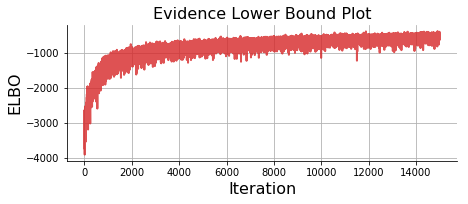

In [20]:
elboplot(-advi.hist);

The ELBO plot tells us it has approached stable performance, so we next look at the means of the parameters and standard deviations of those parameters over iterations, the ELBO comes from `-advi.hist` as in the pymc3 documentation. Now we take a random subset of the model values below (there is structure in the orders, hence the random subset). Note that the behavior tends to be a bit chaotic, and it is not always evident that large changes are happening. The random seed set at the beginning of this notebook should help insulate our example from this problem, however. 

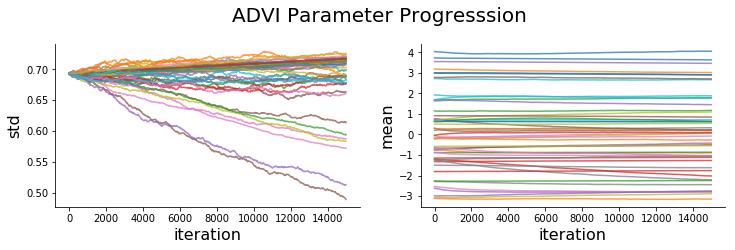

In [21]:
subsamp_fac = 20; iter_array = np.arange(advi.state.i)[::subsamp_fac]
get_weight_mean = lambda i : [tracker['mean'][int(j)][i] for j in iter_array]
get_weight_stds = lambda i : [tracker['std'][int(j)][i] for j in iter_array]

figsize = (12,3); fontsize = 16;
f, axs = plt.subplots(1,2,figsize=figsize)
randset = np.random.choice(len(tracker['mean']),50)
ax = axs[0]
for i in randset:
    ax.plot(iter_array,get_weight_stds(i),alpha=0.75,label=i)
ax.set_xlabel('iteration',fontsize=fontsize); ax.set_ylabel('std',fontsize=fontsize);
ax = axs[1]
for i in randset:
    ax.plot(iter_array,get_weight_mean(i),alpha=0.75,label=i)
ax.set_xlabel('iteration',fontsize=fontsize); ax.set_ylabel('mean',fontsize=fontsize);
f.suptitle("ADVI Parameter Progresssion",fontsize=fontsize+4,y=1.05); sns.despine();

## Test the BBB Model Performance
Now we are ready to draw samples from variational posterior (~weights in the network) we have constructed. To do this we just call `sample` on the approximation. To get performance on the training and test data we construct another two networks `pm_model_perf_train` and `pm_model_perf_test` to sample the posterior predictive distribution, using the trace (posterior samples) from the ADVI approximation above. And for speed's sake we just take a subset of the training data to test the model with (size equal to the training data since it is a more manageable size. We did not find that this yeilded any difference from running on the entire training set.

In [22]:
n_draws = 1000 # > 2k draws hangs for almost all network sizes on a 2018 MBP
n_ppc_samps = 100 # sufficient for our small histograms
trace = approx.sample(draws=n_draws)
# Make performance testing model
shared_x = theano.shared(X_train[:X_test.shape[0]])
shared_y = theano.shared(y_train[:y_test.shape[0]])
pm_model_perf_train = make_1layer_bbb_network(shared_x, shared_y, 
                                   n_input=X_train.shape[1], 
                                   n_output=len(label_dict), 
                                   n_train=y_test.shape[0], 
                                   n_hidden=n_hidden)
with pm_model_perf_train:
    ppc_train = pm.sample_ppc(trace, samples=n_ppc_samps) # deprecated!
# Now do the same for held out test set
pm_model_perf_test = make_1layer_bbb_network(theano.shared(X_test), theano.shared(y_test), 
                                   n_input=X_test.shape[1],
                                   n_output=len(label_dict), 
                                   n_train=X_test.shape[0],
                                   n_hidden=n_hidden)
with pm_model_perf_test:
    ppc_test = pm.sample_ppc(trace, samples=n_ppc_samps) # deprecated!

100%|██████████| 100/100 [00:42<00:00,  2.41it/s]


In [23]:
# Prediction is mode of each
y_pred_train = sp.stats.mode(ppc_train['out'], axis=0).mode[0,:]
y_pred_test = sp.stats.mode(ppc_test['out'], axis=0).mode[0,:]

mean_train_acc = np.mean(y_pred_train==y_train[:y_test.shape[0]])
mean_test_acc = np.mean(y_pred_test==y_test)
print("BBB Model Accuracy:\n  Train {:f}\n  Test  {:f}".format(mean_train_acc,mean_test_acc))

BBB Model Accuracy:
  Train 0.796800
  Test  0.781100


Voila! We get around ~80% accuracy on the training and test sets, similar to in our gradient descent example. Except now we can get a histogram of predictions as part of our posterior predictive check, plotted below...

In [24]:
# make more convenient categorical variables
ppc_test_onehot = tf.keras.utils.to_categorical(ppc_test['out'],num_classes=len(label_dict))
ppc_test_hist = np.sum(ppc_test_onehot,axis=0)
ppc_test_pred = np.argmax(ppc_test_hist,axis=1)

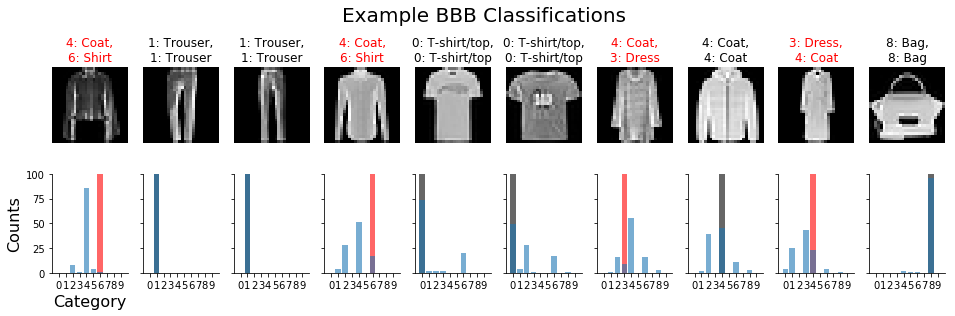

In [25]:
# Plot random subset of images
n_plot_samples = 10
rand_samps = np.random.choice(X_test.shape[0],size=n_plot_samples)

figsize = (16,4); fontsize = 16;
f, axs = plt.subplots(2, n_plot_samples, figsize=figsize);

for i,(rs,ax) in enumerate(zip(rand_samps,axs.T)):
    pred = ppc_test_pred[rs]
    real = y_test[rs]
    # Show image and classifications
    ax[0].imshow(imgvec2img(X_test[rs]),cmap='gray');
    tl = "{}: {},\n{}: {}".format(pred,label_dict[pred],
                                  real,label_dict[real])
    if y_pred_test[rs] == y_test[rs]:
        ax[0].set_title(tl,color='k');
    else:
        ax[0].set_title(tl,color='r');
    ax[0].axis('off');
    
    # Show the classifications as a histogram
    onehot = tf.keras.utils.to_categorical(ppc_test['out'].T[rs],num_classes=len(label_dict))
    if y_pred_test[rs] == y_test[rs]:
        ax[1].bar(real,n_ppc_samps,alpha=0.6,color='k')
    else:
        ax[1].bar(real,n_ppc_samps,alpha=0.6,color='r')
    ax[1].bar(np.arange(len(label_dict)),ppc_test_hist[rs],alpha=0.6)

    ax[1].set_ylim(bottom=0,top=n_ppc_samps)
    ax[1].set_xlim(left=-1,right=10)
    ax[1].set_xticks(np.arange(10))
    if i > 0:
        ax[1].set_yticklabels([])
    else:
        ax[1].set_ylabel("Counts",fontsize=fontsize)
        ax[1].set_xlabel("Category",fontsize=fontsize)
    sns.despine();

f.suptitle("Example BBB Classifications",fontsize=fontsize+4,y=1.05);

Plotting the classification examples, again they very often "make sense" given the similarity of shapes or ambiguity of label. But! We can finally go one step further and see how confident the network was in each of these individual classifications since we have samples from our posterior predictive. Looking below each image is a histogram of the categorizations for each example image across our `n_ppc_samps` samples. The correct category is  indicated in the histogram as a black or red bar at perfect accuracy, for correct and for incorrect modal distributions, respectively.

Now let's break things down by category and look at some performance metrics. Namely, 
 - Fraction of correct predictions by class and confusion matrix,
 - KL divergence from the categorical prior to the empirical classification in each class

The fraction of correct predictions  we  calculate by looking at in vs out of class, so we will throw out any structure in the errors and simply look at if it was right vs wrong. In the confusion matrix we will see if there are classes that are often confused. The KL divergence will tell us the distance between naive performance and actual performance. If looked at in conjunction with accuracy this entropy measure will be a nice way to look at the categorical performance. So we want low standard deviations for all classes, and a high KL divergence between uniform and empirical categorical classification (assuming high accuracy).

In [26]:
# make an array of np.arrays with the inds of all the training indexes for that class
cat_lookup_test = []
for i in range(n_output):
    cat_lookup_test.append([np.array(y_test == i)])

# Things to track
ppc_cat_hists = [] # histograms over each image's samples within a category
ppc_cat_sums = []  # sums of histograms to collapse by category
ppc_cat_accs = []  # fractional corret by category
ppc_cat_stds = []  # standard deviation of each classification point (not super useful)
ppc_cat_ents = []  # entropy of the categorical distributions
ppc_cat_KLDs = []  # KL divergence from the uniform null

y_test_null = np.ones(n_output)/n_output

for i,clt in enumerate(cat_lookup_test):
    ppc_cat_hists.append(ppc_test_hist[clt])
    ppc_cat_sums.append(np.sum(ppc_test_hist[clt],axis=0))
    ppc_cat_accs.append(ppc_cat_sums[i][i]/ppc_cat_sums[i].sum())
    ppc_cat_stds.append(np.std(ppc_test_hist[clt],axis=0))
    normed_cat_hist = ppc_cat_sums[i]/ppc_cat_sums[i].sum()

    ppc_cat_ents.append(sp.stats.entropy(normed_cat_hist))
    ppc_cat_KLDs.append(sp.stats.entropy(normed_cat_hist,y_test_null))

ppc_cat_accs = np.array(ppc_cat_accs) # scalar -> vec
ppc_cat_ents = np.array(ppc_cat_ents) # scalar -> vec
ppc_cat_KLDs = np.array(ppc_cat_KLDs) # scalar -> vec
ppc_cat_sums = np.array(ppc_cat_sums) # vecs -> matrix

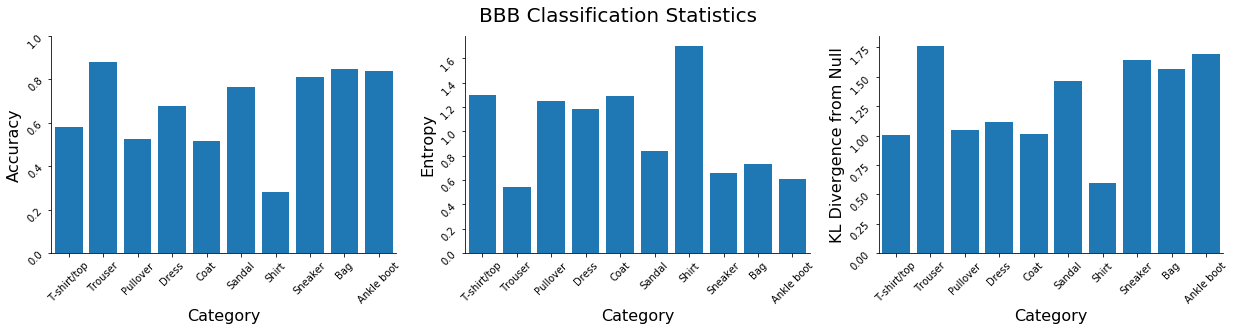

In [27]:
# plot accuracy by class
figsize = (21,4); fontsize = 16;
f, axs = plt.subplots(1, 3, figsize=figsize);

ax=axs[0]
ax.bar(np.arange(n_output),ppc_cat_accs)
ax.set_xlim(left=-0.5,right=9.5)
ax.set_xticks(np.arange(n_output)); ax.tick_params(labelrotation=45);
ax.set_xticklabels(labels=label_dict.values());
ax.set_xlabel("Category",fontsize=fontsize)
ax.set_ylim(bottom=0,top=1)
ax.set_ylabel("Accuracy",fontsize=fontsize)
sns.despine()

ax=axs[1]
ax.bar(np.arange(n_output),ppc_cat_ents)
ax.set_xlim(left=-0.5,right=9.5)
ax.set_xticks(np.arange(n_output)); ax.tick_params(labelrotation=45);
ax.set_xticklabels(labels=label_dict.values());
ax.set_xlabel("Category",fontsize=fontsize)
ax.set_ylabel("Entropy",fontsize=fontsize)
sns.despine()

ax=axs[2]
ax.bar(np.arange(n_output),ppc_cat_KLDs)
ax.set_xlim(left=-0.5,right=9.5)
ax.set_xticks(np.arange(n_output)); ax.tick_params(labelrotation=45);
ax.set_xticklabels(labels=label_dict.values());
ax.set_xlabel("Category",fontsize=fontsize)
ax.set_ylabel("KL Divergence from Null",fontsize=fontsize)
sns.despine()

f.suptitle("BBB Classification Statistics",fontsize=fontsize+4);

In [28]:
# working on melding shayna's plotting functions with mine -SH
#figsize = (7,3); fontsize = 16;
#f, ax = plt.subplots(1, 1, figsize=figsize);
#make_accuracy_histogram(ax, np.swapaxes(ppc_test_onehot.T,2,1), y_test, y_pred_test); sns.despine();

Now we can look at the confusion matricies for the BBB model. 

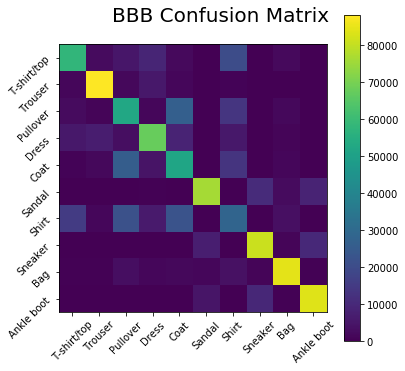

In [29]:
# plot confusion matrix
figsize = (6,6); fontsize = 16;
f, ax = plt.subplots(1, 1, figsize=figsize);

im = ax.imshow(ppc_cat_sums);
ax.set_yticks(np.arange(n_output)); plt.yticks(rotation=45);
ax.set_yticklabels(labels=label_dict.values());
ax.set_xticks(np.arange(n_output)); plt.xticks(rotation=45);
ax.set_xticklabels(labels=label_dict.values());
f.colorbar(im,ax=ax);

f.suptitle("BBB Confusion Matrix",fontsize=fontsize+4,y=0.9);

Again though we can go further and use the probablistic nature of the model to look at uncertainty (STD on prediction) by class. We can also do this by image to find the most "confusing" test images.

In [30]:
#TODO

# quantify uncertainty 
ppc_cat_hists;

# 4. Extending BBB Using Noise Contrastive Priors (NCP)

### Noisy contrastive priors (NCP)

As shown above, Bayesian analysis provides a way to model uncertainty in a neural network. Generally this is done by placing a prior over the weight and bias parameters. We can interpret the parameters of a neural network as adaptive basis coefficients in a nonparametric function, so this approach captures uncertainty about which function best fits the data. However, the induced posterior may not generalize well to to out of distribution (OOD) inputes, which are inputs outside of the distribution that generated the training data.

Ideally, we would like a model that gives high uncertainy for OOD inputs. This can be achieved by using noise contrastive priors (NCP). NCPs approximate OOD samples by convolving the input data with gaussian noise to obtain $\widetilde{x} = x + \epsilon$, where $\epsilon \sim N(\mu, \sigma^2)$. $\mu$ represents the direction in which we apply the prior, and $\sigma^2$ represents how far away from the training sample boundary we sample. For the following experiments we set $\mu = 0$ to apply the prior equal in all directions from the training data, and vary $\sigma$ between 0.01 and 0.1. 

Note that the pixel values in the input images are scaled to be between 0 and 1. Thus, we rescale the noise inputs to be between 0 and 1 by the following transformation:
$$
\widetilde{x}' = \frac{\widetilde{x} - min(\widetilde{x})}{ max(\widetilde{x}) -  min(\widetilde{x})}
$$

Here we define the functions to generate our different sources of noise.

In [31]:
def add_gaussian_noise(X, eps):
    X_noise = X + np.random.normal(0, scale = np.sqrt(eps), size = X.shape)
    min_X,max_X  = np.min(X_noise),np.max(X_noise)
    X_noise = (X_noise - min_X)/(max_X - min_X)
    return(X_noise)
    
def category_type_noise(X, y, categories):
    x_noise = np.zeros(X.shape)
    for c in categories:
        x_cat = X[y == c,:]
        new_x = np.array(list(map(lambda i: np.random.choice(x_cat[:,i],size = x_cat.shape[0],replace = True), range(x_cat.shape[1])))).T
        x_noise[y == c, :] = new_x
    return x_noise

X_cat_noise = category_type_noise(X_train, y_train, range(10))
X_gaus_noise = np.zeros((10,X_train.shape[0],X_train.shape[1]))
sigma_values = np.array(range(1,11))/100

for i in tqdm(range(len(sigma_values))):
    s = sigma_values[i]
    X_gaus_noise[i,:,:] = add_gaussian_noise(X_train, s)

100%|██████████| 10/10 [00:21<00:00,  2.19s/it]


Examples of the noisy inputs are shown below. We see that as we increase the noise in the prior, the objects in the images blend more into the background. 

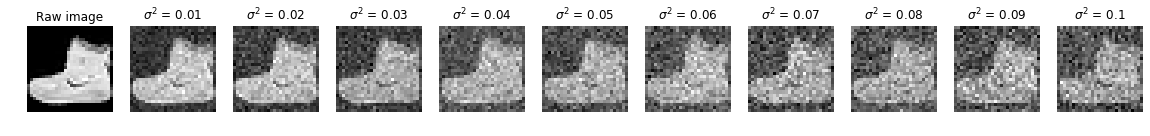

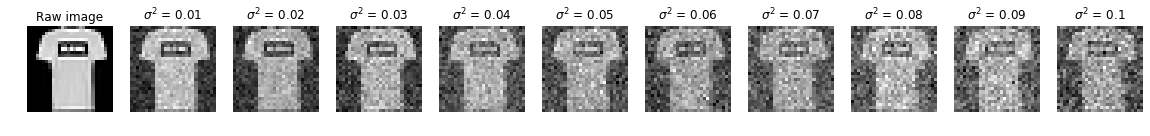

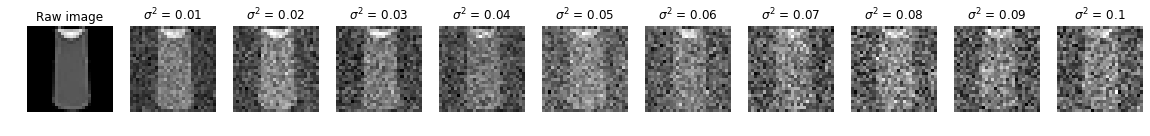

In [32]:
fig = plt.figure(figsize=(20,2))
ax = fig.subplots(1,11)
ax[0].imshow(np.reshape(X_train[0],(28,28)),cmap='gray')
ax[0].set_title("Raw image")
ax[0].axis('off')
#ax[1].imshow(np.reshape(X_cat_noise[0],(28,28)),cmap='gray')
#ax[1].set_title("Category noise")
for i in range(len(sigma_values)):
    ax[i+1].imshow(np.reshape(X_gaus_noise[i,0,:],(28,28)),cmap='gray')
    ax[i+1].set_title(r"$\sigma^2$ = "+str(sigma_values[i]))
    ax[i+1].axis('off')
fig.show()

fig = plt.figure(figsize=(20,2))
ax = fig.subplots(1,11)
ax[0].imshow(np.reshape(X_train[1],(28,28)),cmap='gray')
ax[0].set_title("Raw image")
ax[0].axis('off')
#ax[1].imshow(np.reshape(X_cat_noise[1],(28,28)),cmap='gray')
#ax[1].set_title("Category noise")
for i in range(len(sigma_values)):
    ax[i+1].imshow(np.reshape(X_gaus_noise[i,1,:],(28,28)),cmap='gray')
    ax[i+1].set_title(r"$\sigma^2$ = "+str(sigma_values[i]))
    ax[i+1].axis('off')
fig.show()

fig = plt.figure(figsize=(20,2))
ax = fig.subplots(1,11)
ax[0].imshow(np.reshape(X_train[2],(28,28)),cmap='gray')
ax[0].set_title("Raw image")
ax[0].axis('off')
#ax[1].imshow(np.reshape(X_cat_noise[2],(28,28)),cmap='gray')
#ax[1].set_title("Category noise")
for i in range(len(sigma_values)):
    ax[i+1].imshow(np.reshape(X_gaus_noise[i,2,:],(28,28)),cmap='gray')
    ax[i+1].set_title(r"$\sigma^2$ = "+str(sigma_values[i]))
    ax[i+1].axis('off')
fig.show()

### Out of sample datapoints

One benefit of using NCP is that models trained with NCP produce high uncertainty estimates for out of distribution (OOD), or unseen, datapoints. This prevents over confident predictions on OOD data. In this section we compare the uncertainty of predictions on OOD samples made by BBB and BBB+NCP trained networks. To simulate OOD samples, we remove each of the ten categories one at a time from the training set. We train the network on each of these "leave-one-out" training datasets, and then evaluate the uncertainty of the predictions on the full test set using KL divergence and accuracy. We compare BBB alone to BBB+NCP with $\sigma^2 = \{0.01, 0.05, 1\}$. 

In [33]:
def KL_divergence(q):
    pk = np.full(10, 0.1)
    qk = np.histogram(q, density=True, bins = range(11))[0]
    idx = np.where(qk > 0)
    entropy = sp.stats.entropy(pk[idx], qk[idx])
    return entropy

confusion_matrix = lambda y: np.histogram(y,bins = range(11))[0]

def leave_one_out_training(X, y, c):
    X_ood = X[y != c]
    y_ood = y[y != c]
    
    minibatch_x_ood = pm.Minibatch(X_ood, batch_size=50)
    minibatch_y_ood = pm.Minibatch(y_ood, batch_size=50)
    neural_network_minibatch_ood = make_1layer_bbb_network(minibatch_x_ood, minibatch_y_ood, 784, 10, X_ood.shape[0])

    with neural_network_minibatch_ood:
        inference = pm.ADVI()
        approx_ood = pm.fit(20000, method=inference)
    
    trace_ood = approx_ood.sample(draws=2000)
    
    return trace_ood

def test_network(X, y, trace):
    test_x = theano.shared(X)
    test_y = theano.shared(y)
    neural_network_test = make_1layer_bbb_network(test_x, test_y, 784, 10, X.shape[0])
    with neural_network_test:
        ppc_ood = pm.sample_ppc(trace, samples=100)
    return ppc_ood['out']

Now we make helper plotting functions to use below. 

In [34]:
def plot_test_results(ax, ppc, y_test, title):
    labelnames = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
    std = ppc.std(axis=0)
    std_data = [std[y_test == 0], std[y_test == 1], std[y_test == 2], std[y_test == 3],std[y_test == 4], std[y_test == 5], std[y_test == 6], std[y_test == 7], std[y_test == 8], std[y_test == 9]]
    y_pred_test = sp.stats.mode(ppc, axis=0).mode[0,:]
    
    ax[0].boxplot(std_data)
    ax[0].set_title("Posterior predictive standard deviation")
    ax[0].set_xticklabels(labelnames,rotation=45)
    ax[0].set_ylabel("Standard deviation")
    kl_div = np.array(list(map(lambda i: KL_divergence(y_pred_test[y_test==i]), range(10))))

    ax[1].bar(range(10), kl_div)
    ax[1].set_xticks(range(10))
    ax[1].set_xticklabels(labelnames,rotation=45)
    ax[1].set_ylabel("KL divergence")
    ax[1].set_title("Posterior predictive KL divergence")
    
    conf_mat = np.array(list(map(lambda i: confusion_matrix(y_pred_test[y_test==i]), range(10))))
    im = ax[2].imshow(conf_mat, cmap="gray")
    fig.colorbar(im, ax=ax[2])
    ax[2].set_xticks(np.arange(0, 10, 1))
    ax[2].set_yticks(np.arange(0, 10, 1))
    ax[2].set_xticklabels(labelnames,rotation=45)
    ax[2].set_yticklabels(labelnames,rotation=0)
    ax[2].set_xlabel("Prediction")
    ax[2].set_ylabel("Truth")
    plt.subplots_adjust(top=0.8)
    plt.suptitle(title, fontsize = 20)
    return ax

def plot_KL_divergence_across_datasets(ax, ppc_raw, ppc_g01, ppc_g05, ppc_g1, y_test):
    labelnames = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
    kl_div_raw = np.zeros(10)
    kl_div_g01 = np.zeros(10)
    kl_div_g05 = np.zeros(10)
    kl_div_g1 = np.zeros(10)
    
    for j in range(10):
        y_pred_test_raw = sp.stats.mode(ppc_raw[j,:,:], axis=0).mode[0,:]
        y_pred_test_g01 = sp.stats.mode(ppc_g01[j,:,:], axis=0).mode[0,:]
        y_pred_test_g05 = sp.stats.mode(ppc_g05[j,:,:], axis=0).mode[0,:]
        y_pred_test_g1 = sp.stats.mode(ppc_g1[j,:,:], axis=0).mode[0,:]
        
        kl_div_raw[j] = KL_divergence(y_pred_test_raw[y_test==j])
        kl_div_g01[j] = KL_divergence(y_pred_test_g01[y_test==j])
        kl_div_g05[j] = KL_divergence(y_pred_test_g05[y_test==j])
        kl_div_g1[j] = KL_divergence(y_pred_test_g1[y_test==j])
    
    ax.bar(np.arange(10)-0.3, kl_div_raw, width=0.2, color='orange',align='center', label = "BBB")
    ax.bar(np.arange(10)-0.1, kl_div_g01, width=0.2, color='cyan',align='center', label = r"BBB+NCP, $\sigma^2 = 0.01$")
    ax.bar(np.arange(10)+0.1, kl_div_g05, width=0.2, color='blue',align='center', label = r"BBB+NCP, $\sigma^2 = 0.05$")
    ax.bar(np.arange(10)+0.3, kl_div_g1, width=0.2, color='purple',align='center', label = r"BBB+NCP, $\sigma^2 = 0.1$")
    ax.set_xticks(np.arange(0, 10, 1))
    ax.set_xticklabels(labelnames,rotation=45)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylabel("KL Divergence")
    return ax

def make_accuracy_histogram_across_datasets(ax, ppc_raw, ppc_g01, ppc_g05, ppc_g1, y_test, c, legend):
    labelnames = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
    colorvec = sns.color_palette("hls", 10)
    conf_mat = np.zeros((4,10))
    
    y_pred_test_raw = sp.stats.mode(ppc_raw[c,:,:], axis=0).mode[0,:]
    y_pred_test_g01 = sp.stats.mode(ppc_g01[c,:,:], axis=0).mode[0,:]
    y_pred_test_g05 = sp.stats.mode(ppc_g05[c,:,:], axis=0).mode[0,:]
    y_pred_test_g1 = sp.stats.mode(ppc_g1[c,:,:], axis=0).mode[0,:]
    
    conf_mat[0] = confusion_matrix(y_pred_test_raw[y_test==c])
    conf_mat[1] = confusion_matrix(y_pred_test_g01[y_test==c])
    conf_mat[2] = confusion_matrix(y_pred_test_g05[y_test==c])
    conf_mat[3] = confusion_matrix(y_pred_test_g1[y_test==c])
    
    ax.bar(np.arange(4), conf_mat[:,0], width = 0.5, color = "red", label = labelnames[0])
    bottom = conf_mat[:,0]
    for j in range(1,10):
        ax.bar(np.arange(4), conf_mat[:,j], width = 0.5, bottom = bottom, color = colorvec[j], label = labelnames[j])
        bottom = bottom + conf_mat[:,j]
    ax.set_xticks(np.arange(0, 4, 1))
    ax.set_xticklabels(["BBB",r"BBB+NCP, $\sigma^2$ = 0.01",r"BBB+NCP, $\sigma^2$ = 0.05",r"BBB+NCP, $\sigma^2$ = 0.1"],rotation=45)
    # Put a legend to the right of the current axis
    if legend:
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title("OOD = " + labelnames[c])
    ax.set_ylim(0,1000)
    return ax

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

def make_standard_deviation_plots(ax, ppc_raw, ppc_g01, ppc_g05, ppc_g1, y_test):
    labelnames = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
    
    std_raw = ppc_raw.std(axis=1)
    std_g01 = ppc_g01.std(axis=1)
    std_g05 = ppc_g05.std(axis=1)
    std_g1 = ppc_g1.std(axis=1)
    
    std_raw_data = [std_raw[0, y_test == 0], std_raw[1, y_test == 1], std_raw[2, y_test == 2], std_raw[3, y_test == 3],std_raw[4, y_test == 4], std_raw[5, y_test == 5], std_raw[6, y_test == 6], std_raw[7, y_test == 7], std_raw[8, y_test == 8], std_raw[9, y_test == 9]]
    std_g01_data = [std_g01[0, y_test == 0], std_g01[1, y_test == 1], std_g01[2,y_test == 2], std_g01[3,y_test == 3],std_g01[4,y_test == 4], std_g01[5,y_test == 5], std_g01[6,y_test == 6], std_g01[7,y_test == 7], std_g01[8,y_test == 8], std_g01[9,y_test == 9]]
    std_g05_data = [std_g05[0, y_test == 0], std_g05[1,y_test == 1], std_g05[2,y_test == 2], std_g05[3,y_test == 3],std_g05[4,y_test == 4], std_g05[5,y_test == 5], std_g05[6,y_test == 6], std_g05[7,y_test == 7], std_g05[8,y_test == 8], std_g05[9,y_test == 9]]
    std_g1_data = [std_g1[0, y_test == 0], std_g1[1,y_test == 1], std_g1[2,y_test == 2], std_g1[3,y_test == 3],std_g1[4,y_test == 4], std_g1[5,y_test == 5], std_g1[6,y_test == 6], std_g1[7,y_test == 7], std_g1[8,y_test == 8], std_g1[9,y_test == 9]]
    
    bow_raw = ax.boxplot(std_raw_data, positions=np.arange(10)-0.3, widths=0.2)
    bow_g01 = ax.boxplot(std_g01_data, positions=np.arange(10)-0.1, widths=0.2)
    bow_g05 = ax.boxplot(std_g05_data, positions=np.arange(10)+0.1, widths=0.2)
    bow_g1 = ax.boxplot(std_g1_data, positions=np.arange(10)+0.3, widths=0.2)
    
    set_box_color(bow_raw, 'orange');set_box_color(bow_g01, 'cyan');set_box_color(bow_g05, 'blue');set_box_color(bow_g1, 'purple')
    
    plt.plot([], c='orange', label='BBB')
    plt.plot([], c='cyan', label=r'BBB+NCP, $\sigma^2 = 0.01$')
    plt.plot([], c='blue', label=r'BBB+NCP, $\sigma^2 = 0.05$')
    plt.plot([], c='purple', label=r'BBB+NCP, $\sigma^2 = 0.1$')
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    ax.set_xticks(np.arange(10))
    ax.set_title("Posterior predictive standard deviation")
    ax.set_xticklabels(labelnames,rotation=45)
    ax.set_ylabel("Standard deviation")
    ax.set_xlim(-0.5, 9.5)
    return ax

def make_entropy_plots(ax, ppc_raw, ppc_g01, ppc_g05, ppc_g1, y_test):
    labelnames = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
    
    std_raw = np.array(list(map(lambda j: np.array(list(map(lambda i: sp.stats.entropy(ppc_raw[j,:,i]),range(ppc_raw.shape[2])))), range(ppc_raw.shape[0]))))
    std_g01 = np.array(list(map(lambda j: np.array(list(map(lambda i: sp.stats.entropy(ppc_g01[j,:,i]),range(ppc_g01.shape[2])))), range(ppc_g01.shape[0]))))
    std_g05 = np.array(list(map(lambda j: np.array(list(map(lambda i: sp.stats.entropy(ppc_g05[j,:,i]),range(ppc_g05.shape[2])))), range(ppc_g05.shape[0]))))
    std_g1 = np.array(list(map(lambda j: np.array(list(map(lambda i: sp.stats.entropy(ppc_g1[j,:,i]),range(ppc_g1.shape[2])))), range(ppc_g1.shape[0]))))

    std_raw_data = [std_raw[0, y_test == 0], std_raw[1, y_test == 1], std_raw[2, y_test == 2], std_raw[3, y_test == 3],std_raw[4, y_test == 4], std_raw[5, y_test == 5], std_raw[6, y_test == 6], std_raw[7, y_test == 7], std_raw[8, y_test == 8], std_raw[9, y_test == 9]]
    std_g01_data = [std_g01[0, y_test == 0], std_g01[1, y_test == 1], std_g01[2,y_test == 2], std_g01[3,y_test == 3],std_g01[4,y_test == 4], std_g01[5,y_test == 5], std_g01[6,y_test == 6], std_g01[7,y_test == 7], std_g01[8,y_test == 8], std_g01[9,y_test == 9]]
    std_g05_data = [std_g05[0, y_test == 0], std_g05[1,y_test == 1], std_g05[2,y_test == 2], std_g05[3,y_test == 3],std_g05[4,y_test == 4], std_g05[5,y_test == 5], std_g05[6,y_test == 6], std_g05[7,y_test == 7], std_g05[8,y_test == 8], std_g05[9,y_test == 9]]
    std_g1_data = [std_g1[0, y_test == 0], std_g1[1,y_test == 1], std_g1[2,y_test == 2], std_g1[3,y_test == 3],std_g1[4,y_test == 4], std_g1[5,y_test == 5], std_g1[6,y_test == 6], std_g1[7,y_test == 7], std_g1[8,y_test == 8], std_g1[9,y_test == 9]]
    
    bow_raw = ax.boxplot(std_raw_data, positions=np.arange(10)-0.3, widths=0.2)
    bow_g01 = ax.boxplot(std_g01_data, positions=np.arange(10)-0.1, widths=0.2)
    bow_g05 = ax.boxplot(std_g05_data, positions=np.arange(10)+0.1, widths=0.2)
    bow_g1 = ax.boxplot(std_g1_data, positions=np.arange(10)+0.3, widths=0.2)
    
    set_box_color(bow_raw, 'orange')
    set_box_color(bow_g01, 'cyan')
    set_box_color(bow_g05, 'blue')
    set_box_color(bow_g1, 'purple')
    
    plt.plot([], c='orange', label='BBB')
    plt.plot([], c='cyan', label=r'BBB+NCP, $\sigma^2 = 0.01$')
    plt.plot([], c='blue', label=r'BBB+NCP, $\sigma^2 = 0.05$')
    plt.plot([], c='purple', label=r'BBB+NCP, $\sigma^2 = 0.1$')
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xticks(np.arange(10))
    ax.set_title("Posterior predictive entropy")
    ax.set_xticklabels(labelnames,rotation=45)
    ax.set_ylabel("Entropy")
    ax.set_xlim(-0.5, 9.5)
    return ax

def plot_entropy_across_datasets(ax, ppc_raw, ppc_g01, ppc_g05, ppc_g1, y_test):
    labelnames = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
    kl_div_raw = np.zeros(10)
    kl_div_g01 = np.zeros(10)
    kl_div_g05 = np.zeros(10)
    kl_div_g1 = np.zeros(10)
    
    for j in range(10):
        y_pred_test_raw = sp.stats.mode(ppc_raw[j,:,:], axis=0).mode[0,:]
        y_pred_test_g01 = sp.stats.mode(ppc_g01[j,:,:], axis=0).mode[0,:]
        y_pred_test_g05 = sp.stats.mode(ppc_g05[j,:,:], axis=0).mode[0,:]
        y_pred_test_g1 = sp.stats.mode(ppc_g1[j,:,:], axis=0).mode[0,:]
        
        kl_div_raw[j] = sp.stats.entropy(y_pred_test_raw[y_test==j])
        kl_div_g01[j] = sp.stats.entropy(y_pred_test_g01[y_test==j])
        kl_div_g05[j] = sp.stats.entropy(y_pred_test_g05[y_test==j])
        kl_div_g1[j] = sp.stats.entropy(y_pred_test_g1[y_test==j])
    
    ax.bar(np.arange(10)-0.3, kl_div_raw, width=0.2, color='orange',align='center', label = "BBB")
    ax.bar(np.arange(10)-0.1, kl_div_g01, width=0.2, color='cyan',align='center', label = r"BBB+NCP, $\sigma^2 = 0.01$")
    ax.bar(np.arange(10)+0.1, kl_div_g05, width=0.2, color='blue',align='center', label = r"BBB+NCP, $\sigma^2 = 0.05$")
    ax.bar(np.arange(10)+0.3, kl_div_g1, width=0.2, color='purple',align='center', label = r"BBB+NCP, $\sigma^2 = 0.1$")
    ax.set_xticks(np.arange(0, 10, 1))
    ax.set_xticklabels(labelnames,rotation=45)
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylabel("Entropy")
    return ax

KL divergence is one metric for assesing model prediction uncertainty. The posterior predictive distribution is compared to a uniform distribution, so a small KL divergence suggests the posterior is closer to a uniform distribution, or more uncertain, whereas a large KL divergence suggests the posterior is further away from a uniform, or more certain about class assignment. The histogram below shows the KL divergences of the posterior predictive distributions of the classes when they left out during training. For example, the T-shirt/top bars represent the KL divergence of the T-shirt/top posterior predictive distribution when T-shirt/top samples are left out during training. We see that the KL divergence decreases as $\sigma^2$ increases for Coat, Sandal, and Bag, suggesting that the uncertainty of making predictions on these classes when they are OOD increases as the noise in the noisy prior increases, which is what we expect. While there is no clean discernible pattern for the other class posterior distributions, the KL divergence is always higher for BBB than BBB+NCP when $\sigma^2 = 0.1$. This means that the neural network is generally more confident on OOD samples when is is not trained with a noisy prior.

Now we load in or perform posterior predictive checks.

In [35]:
# Choose to load pickled data or not
load_pickle = True

if load_pickle:
    print("Loading pickled data.")
    with open('./data/ncp_ppc_rawdata.pickle', 'rb') as f:
        ppc_rawdata = pickle.load(f)
        
    with open('./data/ncp_ppc_gaus_01.pickle', 'rb') as f:
        ppc_gaus_01 = pickle.load(f)
        
    with open('./data/ncp_ppc_gaus_05.pickle', 'rb') as f:
        ppc_gaus_05 = pickle.load(f)
        
    with open('./data/ncp_ppc_gaus_1.pickle', 'rb') as f:
        ppc_gaus_1 = pickle.load(f)
else:
    ppc_rawdata = np.zeros((10,100,10000))
    for i in range(10):
        trace_rawdata = leave_one_out_training(X_train, y_train, i)
        ppc_rawdata[i,:,:] = test_network(X_test, y_test, trace_rawdata)
    with open('./data/ncp_ppc_rawdata.pickle', 'wb') as f:
        pickle.dump(ppc_rawdata, f)   

    ppc_gaus_01 = np.zeros((10,100,10000))
    for i in range(10):
        trace_gaus_01 = leave_one_out_training(X_gaus_noise[0,:,:], y_train, i)
        ppc_gaus_01[i,:,:] = test_network(X_test, y_test, trace_gaus_01)
    with open('./data/ncp_ppc_gaus_01.pickle', 'wb') as f:
         pickle.dump(ppc_gaus_01, f)
            
    ppc_gaus_05 = np.zeros((10,100,10000))
    for i in range(10):
        trace_gaus_05 = leave_one_out_training(X_gaus_noise[4,:,:], y_train, i)
        ppc_gaus_05[i,:,:] = test_network(X_test, y_test, trace_gaus_05)
    with open('./data/ncp_ppc_gaus_05.pickle', 'wb') as f:
         pickle.dump(ppc_gaus_05, f)

    ppc_gaus_1 = np.zeros((10,100,10000))
    for i in range(10):
        trace_gaus_1 = leave_one_out_training(X_gaus_noise[9,:,:], y_train, i)
        ppc_gaus_1[i,:,:] = test_network(X_test, y_test, trace_gaus_1)
    with open('./data/ncp_ppc_gaus_1.pickle', 'wb') as f:
         pickle.dump(ppc_gaus_1, f)

Loading pickled data.


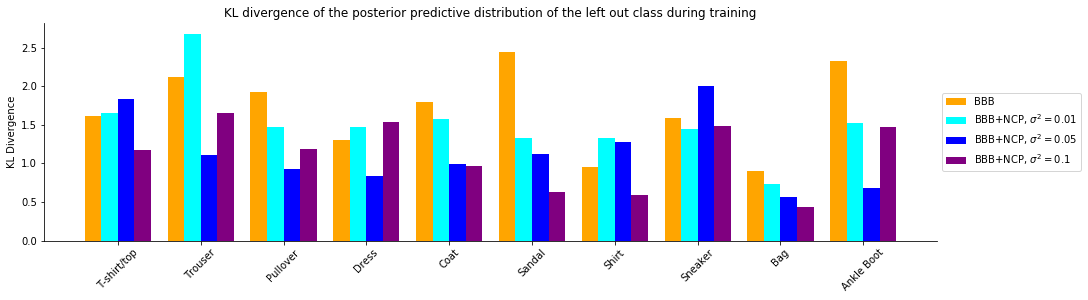

In [36]:
fig, ax = plt.subplots(figsize=(20,4));
plot_KL_divergence_across_datasets(ax, ppc_rawdata, ppc_gaus_01, ppc_gaus_05, ppc_gaus_1,y_test);
ax.set_title("KL divergence of the posterior predictive distribution of the left out class during training"); sns.despine();

We also used standard deviation of the posterior predictive distribution to assess uncertainty. The boxplots below show the standard deviations of of the posterior predictive distributions of the classes when they are left out during training. For example, the T-shirt/top boxplots represent the standard deviation of the T-shirt/top posterior distribution when the T-shirt/top samples are left out during training. We see that the standard deviation of the posterior distributions increase as the noise in the NCP increases for all classes. This suggests that the network is more uncertain about the class assignments of OOD samples when the model is trained on noisier input data, which is what we expect. 

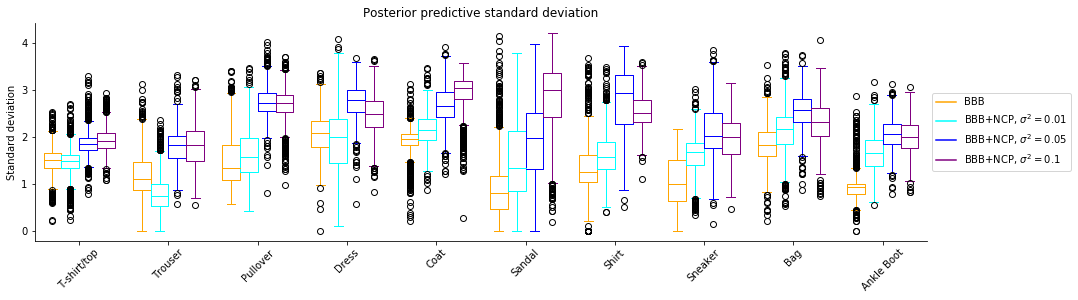

In [37]:
fig, ax = plt.subplots(figsize=(20,4));
make_standard_deviation_plots(ax, ppc_rawdata, ppc_gaus_01, ppc_gaus_05, ppc_gaus_1, y_test); sns.despine();

The plots below show the posterior predictive distribution for each setting. Each individual plots represents the posterior distribution of a particular class when that class is left out of the training sample. Each bar in the plot represents either BBB or BBB+NCP with a particular value of $\sigma^2$. In general, we see that when the model is trained using BBB only, the class assignments are split between fewer classes, and when the model is trained with BBB+NCP, the class assignments are split between more classes. This suggests that using NCP increases the uncertainty of OOD samples.  

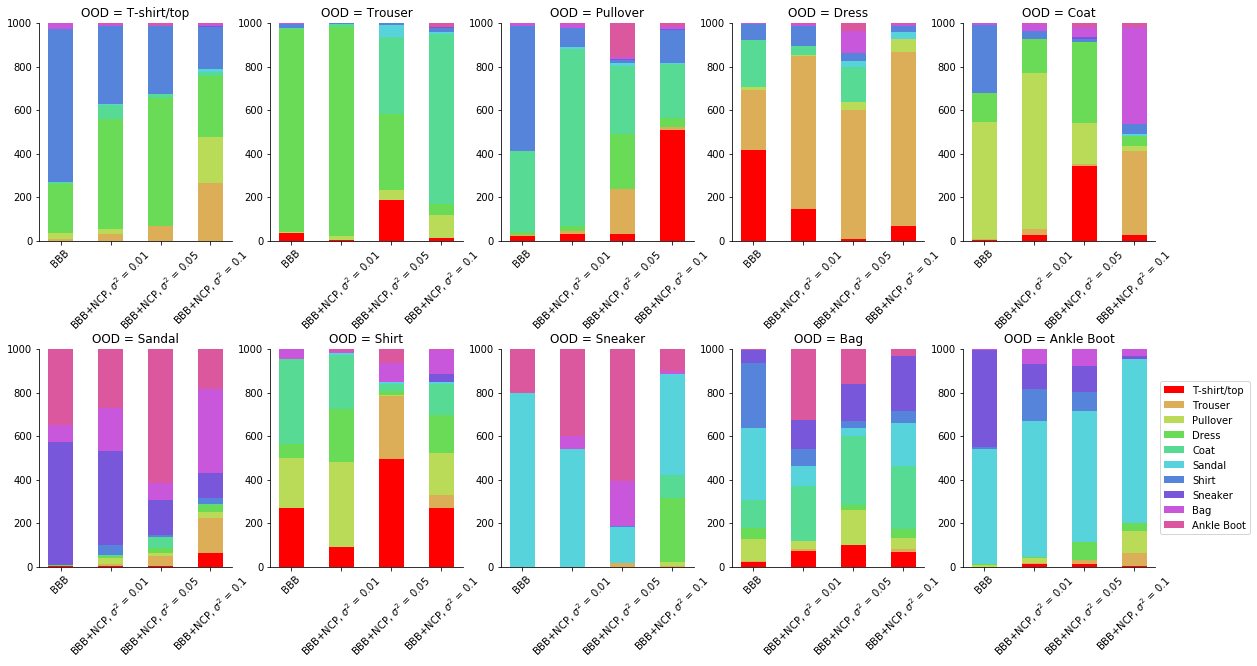

In [38]:
fig,ax = plt.subplots(2,5, figsize=(20,10));
make_accuracy_histogram_across_datasets(ax[0,0], ppc_rawdata, ppc_gaus_01, ppc_gaus_05, ppc_gaus_1, y_test, 0, False);
make_accuracy_histogram_across_datasets(ax[0,1], ppc_rawdata, ppc_gaus_01, ppc_gaus_05, ppc_gaus_1, y_test, 1, False);
make_accuracy_histogram_across_datasets(ax[0,2], ppc_rawdata, ppc_gaus_01, ppc_gaus_05, ppc_gaus_1, y_test, 2, False);
make_accuracy_histogram_across_datasets(ax[0,3], ppc_rawdata, ppc_gaus_01, ppc_gaus_05, ppc_gaus_1, y_test, 3, False);
make_accuracy_histogram_across_datasets(ax[0,4], ppc_rawdata, ppc_gaus_01, ppc_gaus_05, ppc_gaus_1, y_test, 4, False);
make_accuracy_histogram_across_datasets(ax[1,0], ppc_rawdata, ppc_gaus_01, ppc_gaus_05, ppc_gaus_1, y_test, 5, False);
make_accuracy_histogram_across_datasets(ax[1,1], ppc_rawdata, ppc_gaus_01, ppc_gaus_05, ppc_gaus_1, y_test, 6, False);
make_accuracy_histogram_across_datasets(ax[1,2], ppc_rawdata, ppc_gaus_01, ppc_gaus_05, ppc_gaus_1, y_test, 7, False);
make_accuracy_histogram_across_datasets(ax[1,3], ppc_rawdata, ppc_gaus_01, ppc_gaus_05, ppc_gaus_1, y_test, 8, False);
make_accuracy_histogram_across_datasets(ax[1,4], ppc_rawdata, ppc_gaus_01, ppc_gaus_05, ppc_gaus_1, y_test, 9, True);
plt.subplots_adjust(hspace=0.5); sns.despine();

# 5. BBB for Active Learning

## Application: Active Learning with Fashion MNIST

One of the main benefits of using a Bayesian Neural Network is that it is possile to drive learning online accoring to where the network is most uncertain. This is often referred to as active learning. We are going to apply active learning to training a BNN for classification on the fashion_mnist dataset. Our hope is that we can speed up learning by feeding the network data according to which categories it is the most uncertain about. 

**Brief Overview**

When we started working on this problem we were suprised to see that with a very small fraction of the training dataset we still got decent performance on the test set with our BNN. For example, with the full training dataset (60,000 images) we get a test set performance of 77%, while with only 300 data points we still get 71% performance. This was based on 10K iterations (~8 epochs), so it is possible that the assymptoic performance of the networks with this amount of data would be more different. In any case, these findings made us interested in how performance depends on the number of data points. 

In order to investigate this we trained a network on varying amounts of training data. This would have taken a very long time with our BNN, so instead we used a network with the same structure, but trained with adam in tensorflow. We found that the learning curve as a function of training data is highly nonlinear. Specifically, there is a large increase in performance between 50 and 200 training data points, and then a linear increase between 200 and 60000. 

For the purpose of exploring active learning with this example dataset, we are going to focus on speeding up the improvement in performance within the first ~500 training data points seen. 

**Outline**

1. Get an idea the learning curve as a function of the amount of training data
2. Example of training on subset of data and assessing uncertainty
3. Active learning application

### 1) Assess test performance as a function of number of training data points

Before moving on with active learning, we want to get a sense of how test set performace depends on the number of training samples. It would be pretty slow to look at this with out pymc3 model, but we can use Adam optimization in tensorflow to get an idea of the learning curve on an ANN. 

In [39]:
tf_model = make_1layer_tf_network(X_train.shape[1],n_output=len(label_dict),n_hidden=128);
tf_model.fit(X_train, y_train, epochs=5, verbose=0);
print('5 Epoch Test accuracy:', tf_model.evaluate(X_test, y_test)[1])

10000/10000 [==============================] - 0s 15us/step
5 Epoch Test accuracy: 0.8415


#### Functions for trainining on subset and assessing uncertainty

In [40]:
def get_training_subset(X_train, y_train, n_samples):
    (n_train, n_input) = np.shape(X_train)
    n_cat = 10
    if n_train == n_samples:
        return X_train, y_train
    # make n_samples a multiple of 10 for ease of balancing the dataset
    n_cat_samples = int(n_samples/10)
    # get appropraite number of samples from each category
    cat_ind = list()
    ind_array = np.arange(n_train)
    for cat in range(n_cat):
        cat_ind = np.append(cat_ind, np.random.choice(ind_array[y_train == cat], size=n_cat_samples, replace=False))
    np.random.shuffle(cat_ind)
    X_train_subset = X_train[cat_ind.astype(int)]
    y_train_subset = y_train[cat_ind.astype(int)]
    return X_train_subset, y_train_subset

def get_cat_entropy(X_test, y_test, ppc_test):
    # get other parameters that need
    (n_test,n_input) = X_test.shape
    n_output = 10
    n_samples = np.shape(ppc_test['out'])[0]
    
    # make one-hot matrix
    one_hot = np.zeros((n_samples, n_test, n_output))
    for i in range(n_samples):
        one_hot[i][np.arange(n_test), ppc_test['out'][i]] = 1
    
    # make histograms 
    y_test_dist = np.histogram(y_test, bins=n_output)[0]
    cat_hist = np.zeros((n_output, n_output))
    cat_entropy = np.zeros(n_output)
    cat_KL = np.zeros(n_output)
    histograms = np.sum(one_hot, axis=0)
    for i in range(n_output):
        cat_hist[i,:] = np.sum(histograms[y_test == i], axis=0)
        cat_entropy[i] = sp.stats.entropy(cat_hist[i,:])
        cat_KL[i] = sp.stats.entropy(cat_hist[i,:], y_test_dist)
#         cat_KL[i] = sp.stats.entropy(y_test_dist, cat_hist[i,:])
    return one_hot, cat_hist, cat_entropy, cat_KL

In [41]:
n_samples_vec = [10,20, 30, 40, 50, 70, 100, 150, 200, 500, 1000, 10000, 60000]
n_trials = 10
load_pickle = True
if load_pickle:
    with open('./data/act_learn_perf_dict_1.pickle', 'rb') as f:
        perf_dict = pickle.load(f)
else:
    test_acc_results = np.zeros((len(n_samples_vec), n_trials))
    for i, n_samples in enumerate(n_samples_vec):
        print(n_samples)
        for j in range(n_trials):
            X_train_subset, y_train_subset = get_training_subset(X_train, y_train, n_samples)
            tf_model = make_1layer_tf_network(X_train_subset.shape[1],n_output=len(label_dict),n_hidden=128)
            tf_model.fit(X_train_subset, y_train_subset, epochs=5, verbose=0);
            test_acc_results[i,j] = tf_model.evaluate(X_test, y_test)[1]; #test_acc_results[i,j] = tf_model(X_train_subset, y_train_subset);
    perf_dict = {'test_acc_results' : test_acc_results,'n_samples_vec' : n_samples_vec,
                 'mean' : np.mean(test_acc_results, axis=1),'std' : np.std(test_acc_results, axis=1)}
    with open('./data/act_learn_perf_dict_1.pickle', 'wb') as f:
         pickle.dump(perf_dict, f)

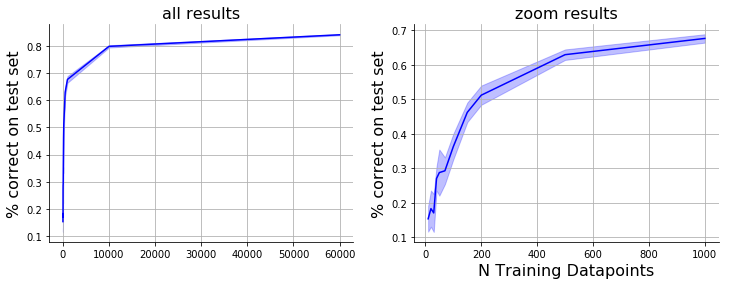

In [42]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(perf_dict['n_samples_vec'], perf_dict['mean'], c='blue')
ax[0].fill_between(perf_dict['n_samples_vec'], 
                 perf_dict['mean'] + perf_dict['std'],
                 perf_dict['mean'] -  perf_dict['std'],
                 color='blue' , alpha=.25)
ax[1].set_xlabel('N Training Datapoints',fontsize=fontsize);
ax[0].set_ylabel('% correct on test set',fontsize=fontsize);
ax[0].grid('on'); ax[0].set_title('all results',fontsize=fontsize);

num_points_zoom = 11
ax[1].plot(perf_dict['n_samples_vec'][:num_points_zoom], perf_dict['mean'][:num_points_zoom], c='blue')
ax[1].fill_between(perf_dict['n_samples_vec'][:num_points_zoom], 
                 perf_dict['mean'][:num_points_zoom] + perf_dict['std'][:num_points_zoom],
                 perf_dict['mean'][:num_points_zoom] -  perf_dict['std'][:num_points_zoom],
                 color='blue' , alpha=.25)
ax[1].set_xlabel('N Training Datapoints',fontsize=fontsize);
ax[1].set_ylabel('% correct on test set',fontsize=fontsize);
ax[1].set_title('zoom results',fontsize=fontsize); 
ax[1].grid('on'); sns.despine();

#### Conclusion from Active Learning Part 1

The relationship between the number of training data points and test set performance is highly nonlinear. We see a large jump in performance between 10 and 200 training data points, and then a slight increase from then on. As mentioned abve, we are going to focus on increasing the speed of learning at the beginning of training (~500 training points). 

### 2) Example of training network on subset of data and assessing uncertainty


We will now go through an example of training a BNN on a subset of the data. We will used a balanced subset of 200 training data points. As we will from the confusion matrix, there is an uneven distribution of uncertainty across categories. Hopefully by using active learning, we can give the network appropraite data during training to efficiently reduce the uncertainty.  

#### Train Network on subset of data

In [43]:
n_samples = 200
X_train_subset, y_train_subset = get_training_subset(X_train, y_train, n_samples)
NN_model = make_1layer_bbb_network(X_train_subset, y_train_subset, n_input=X_train_subset.shape[1], n_output=len(label_dict), n_train=X_train_subset.shape[0], n_hidden=128,use_bias=False)

In [44]:
n_approx_iter = 5000
with NN_model:
    advi = pm.ADVI()
    approx = advi.fit(n=n_approx_iter)

Average Loss = 73,189: 100%|██████████| 5000/5000 [02:26<00:00, 34.22it/s]
Finished [100%]: Average Loss = 72,969


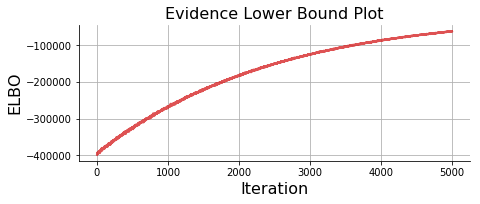

In [45]:
elboplot(-advi.hist);

#### Test this network performance on test set

In [46]:
# network at performance on the test set
trace = approx.sample(draws=500)
NN_model_test = make_1layer_bbb_network(theano.shared(X_test),theano.shared(y_test), n_input=X_test.shape[1], n_output=len(label_dict), n_train=X_test.shape[0], n_hidden=128,use_bias=False)
n_samples = 100
with NN_model_test:
    ppc_test = pm.sample_ppc(trace, samples=n_samples)

100%|██████████| 100/100 [00:48<00:00,  2.16it/s]


In [47]:
# Prediction is mode of each
test_y_pred = sp.stats.mode(ppc_test['out'], axis=0).mode[0,:]
print("Network Test Set Performance: {:f}".format(np.mean(test_y_pred==y_test)))

Network Test Set Performance: 0.694300


#### Evaluate uncertainty within each category

Here we are measurign uncertainty as the KL between the network categorization and the actual distribution of y labels. If the training set is balance, the distribution of y labels will be a uniform distibution. A category that outputs almost a unifrom distribution is very uncertain (low KL), while a network that outputs something close to a one-hot vector is very certain (high KL). Consequently, a category with low KL has high uncertainty, and a category with high KL has low uncertainty.

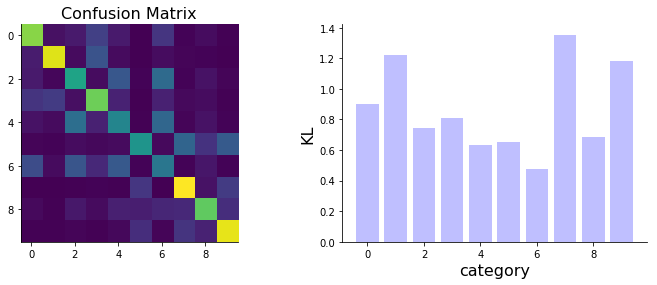

In [48]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
one_hot, cat_hist, cat_entropy, cat_KL = get_cat_entropy(X_test, y_test, ppc_test)
ax[0].imshow(cat_hist)
ax[0].set_title('Confusion Matrix',fontsize=fontsize);
ax[1].bar(np.arange(10), cat_KL, color='blue', alpha=.25);
ax[1].set_xlabel('category',fontsize=fontsize);
ax[1].set_ylabel('KL',fontsize=fontsize); sns.despine();

#### Conclusion from Part 2
These results are pretty interesting. We already get pretty good performance (70%), but it is clear that some categories (e.g. 4: coat, 5: sandals, 6: shirt), are much more uncertain than other categories (e.g. 7: sneaker, or 9: ankle boot). We will see if we can remedy this with active learning. 

### 3) Full example

#### Pseudocode

- Train network on subset of training data
- while i < n_iterations:
    - assess category uncertainty of network
    - choose 5 training samples from  category with largest uncertainty 
    - choose 50 already seen samples from training data to replay proportional to category uncertainty
    - train network using replay and new data
    - i += 1

**1) How to assess uncertainty while training?** In order to assess the uncertainty of the network we are going to test the network on training data that it has already seen. We want to assess this prior to feeding the network more data. If we were to assess the uncertainty on all seen data, this would take a long time. The benefit of the BBN is that we can get a measure of uncertainty for a single data point. This is still a bit noisy if we want to find the overal category with the highest uncertainty. We choose to assess the uncertainty using 3 data points from each category. 

**2) How many data points should we feed the network after assessing the uncertainty?** We want to avoid overfitting by feeding the network tons of data in a row from the same category. In order to avoid this we will feed the network data in chunks of 5. Also, since the uncertainty assessment is bound to be slightly noisy, we will probably not consistently identify one category as the most uncertain. This will also help avoid overfitting. 

**3) How to use multiple epochs with active learning?** One complication that comes up with active learning is how to adapt the idea of training over multiple epochs of the data. The example aboce runs through about 8 epochs of the training set subset. If it only does 1 epoch, performance is much worse. In order to mimic going though multiple epochs, we will introduce experience replay in conjunction with active learning. For expereince replay, we will choose 10 already seen training points in proportion to the uncertainty of each category.  

#### Code for active learning

**Functions for running active learning and control network**

Note the BBB network we use here is identical to the one used above, except that we are no longer using minibatches.

In [49]:
def initialize_network(X_train, y_train, n_samples, n_epochs, n_hidden):
    X_train_init, y_train_init, ind_used, ind_remaining = get_training_subset_init(X_train, y_train, n_samples)
    shared_x = theano.shared(X_train_init)
    shared_y = theano.shared(y_train_init)

    # make neural network
    (n_train,n_input) = X_train_init.shape
    #NN_model = construct_nn_active_learning(shared_x, shared_y, n_input, n_output, n_hidden=n_hidden)
    NN_model = make_1layer_bbb_network(shared_x, shared_y, n_input=n_input, n_output = len(label_dict), 
                                       n_train=n_train, n_hidden=128 ,use_bias=False, allow_minibatch=False)
    # train network on initial subset of data
    n_approx_iter = n_samples*n_epochs
    with NN_model:
        advi = pm.ADVI()
        approx = advi.fit(n=n_approx_iter)
        
    return NN_model, advi, approx, ind_used, ind_remaining

def run_active_learning(NN_model_active, advi_active, ind_used, ind_remaining, n_active_learning_iterations, n_test_uncertainty,
                        n_cat_data_points, n_replay_data_points):
    i = 1
    replay_ind_list = ()
    while i < n_active_learning_iterations: #samples_remaining:
        print(i)
        # evaluate current uncertainty and find category with max uncertainty
        cat_KL, cat = get_max_uncertainty(X_train, y_train, ind_used, n_test_uncertainty)
        # get n_cat_data_points new training data from that category
        X_train_cat, y_train_cat, ind_used, ind_remaining = \
                get_cat_subset(X_train, y_train, ind_used, ind_remaining, n_cat_data_points, cat)
        # get replay training data proportional to current uncertainty
        X_train_replay, y_train_replay, replay_ind_list = \
            get_replay_subset(X_train, y_train, ind_used, cat_KL, n_replay_data_points, replay_ind_list)
        # concatenate training data for this active learning iteration
        X_train_subset = np.vstack((X_train_cat, X_train_replay))
        y_train_subset = np.append(y_train_cat, y_train_replay)
        # continue training network on this data
        shared_x.set_value(X_train_subset)
        shared_y.set_value(y_train_subset)
        n_iterations = len(y_train_subset)
        with NN_model_active:
            approx_active = advi_active.fit(n=n_iterations)
        i += 1
    return advi_active, approx_active, ind_used, replay_ind_list
                        
def run_active_learning_control(NN_model_control, advi_control, ind_used, ind_remaining, n_active_learning_iterations,
                                n_cat_data_points, n_replay_data_points):
    i = 1
    replay_ind_list = list()
    while i < n_active_learning_iterations: #samples_remaining:
        print(i)
        # choose random category to feed data
        cat = np.random.choice(n_output)
        # get n_cat_data_points new training data from that category
        X_train_cat, y_train_cat, ind_used, ind_remaining = \
                get_cat_subset(X_train, y_train, ind_used, ind_remaining, n_cat_data_points, cat)
        # get balanced replay training data
        X_train_replay, y_train_replay, replay_ind_list = \
            get_replay_subset_balanced(X_train, y_train, ind_used, n_replay_data_points, replay_ind_list)
        # concatenate training data for this active learning iteration
        X_train_subset = np.vstack((X_train_cat, X_train_replay))
        y_train_subset = np.append(y_train_cat, y_train_replay)
        # continue training network on this data
        shared_x.set_value(X_train_subset)
        shared_y.set_value(y_train_subset)
        n_iterations = len(y_train_subset)
        with NN_model_control:
            approx_control = advi_control.fit(n=n_iterations)
        i += 1
    return advi_control, approx_control, ind_used, replay_ind_list

**Helper functions**

In [50]:
def get_training_subset_init(X_train, y_train, n_samples):
    # make n_samples a multiple of 10 for ease of balancing the dataset
    n_cat = 10
    n_cat_samples = int(n_samples/10)
    n_train = np.shape(X_train)[0]
    ind_array = np.arange(n_train)
    
    # make cat list
    ind_remaining = list()
    for i in range(10):
        ind_remaining.append(ind_array[y_train == i])
    
    ind_used = [[]]*n_cat
    ind_subset = list()
    for cat in range(n_cat):
        cat_ind = np.random.choice(ind_remaining[cat], size=n_cat_samples, replace=False).astype(int)
        ind_remaining[cat] = np.delete(ind_remaining[cat], np.argwhere(np.in1d(ind_remaining[cat], cat_ind)))
        ind_used[cat] = np.append(ind_used[cat], cat_ind)
        ind_subset = np.append(ind_subset, cat_ind)
    ind_subset = ind_subset.astype(int)
    np.random.shuffle(ind_subset)
    X_train_subset = X_train[ind_subset]
    y_train_subset = y_train[ind_subset]
    return X_train_subset, y_train_subset, ind_used, ind_remaining

def get_cat_subset(X_train, y_train, ind_used, ind_remaining, n_samples, cat):
    # get appropraite number of samples from given category
    cat_ind = np.random.choice(ind_remaining[cat], size=n_samples, replace=False).astype(int)
    ind_used[cat] = np.append(ind_used[cat], cat_ind)
    ind_remaining[cat] = np.delete(ind_remaining[cat], np.argwhere(np.in1d(ind_remaining[cat], cat_ind)))
    X_train_subset = X_train[cat_ind]
    y_train_subset = y_train[cat_ind]
    return X_train_subset, y_train_subset, ind_used, ind_remaining

def get_used_subset(X_train, y_train, ind_used, n_samples):
    n_cat = 10
    n_cat_samples = int(n_samples/n_cat)
    cat_ind_list = list()
    for cat in range(n_cat):
        cat_ind = np.random.choice(ind_used[cat], size=n_cat_samples, replace=False)
        cat_ind_list = np.append(cat_ind_list, cat_ind)
    cat_ind_list = cat_ind_list.astype(int)
    X_used_subset = X_train[cat_ind_list]
    y_used_subset = y_train[cat_ind_list]
    return X_used_subset, y_used_subset

def get_max_uncertainty(X_train, y_train, ind_used, n_samples):
    X_used_subset, y_used_subset = get_used_subset(X_train, y_train, ind_used, n_samples)
    (n_test,n_input) = X_test.shape
    X_used_shared = theano.shared(X_used_subset)
    y_used_shared = theano.shared(y_used_subset)
    n_input = 28*28
    n_output = 10
    #NN_model_test = construct_nn_active_learning(X_used_shared, y_used_shared, n_input, n_output, n_hidden=128)
    NN_model_test = make_1layer_bbb_network(X_used_shared, y_used_shared, n_input=X_used_subset.shape[1], n_output=len(label_dict), 
                                            n_train=X_used_subset.shape[0], n_hidden=128, use_bias=False, allow_minibatch=False)
    n_samples = 100
    with NN_model_test:
        ppc_test = pm.sample_ppc(trace, samples=n_samples)
    one_hot, cat_hist, cat_entropy, cat_KL = get_cat_entropy(X_used_subset, y_used_subset, ppc_test)
    return cat_KL, np.argmin(cat_KL)

def get_replay_subset(X_train, y_train, ind_used, cat_KL, n_samples, replay_ind_list):
    cat_KL_scaled = ((cat_KL - np.min(cat_KL))/(np.max(cat_KL) - np.min(cat_KL)))
    p_vals = (1 - cat_KL_scaled)/np.sum(cat_KL_scaled)
    p_vals /= np.sum(p_vals)
    n_cat_samples = np.round((p_vals*n_samples)).astype(int)
    cat_ind_list = list()
    for cat, n_cat_samp in enumerate(n_cat_samples):
        if n_cat_samp < len(ind_used[cat]):
            cat_ind = np.random.choice(ind_used[cat], size=n_cat_samp, replace=False)
        elif n_cat_samp > len(ind_used[cat]):
            cat_ind = ind_used[cat]
            n_ind_left = n_cat_samp - len(ind_used[cat])
            ind_used_list = [item for cat_used in ind_used for item in cat_used]
            extra_ind = np.random.choice(ind_used_list, size=n_ind_left, replace=False)
            cat_ind = np.append(cat_ind, extra_ind)
        elif n_cat_samp == len(ind_used[cat]):
            cat_ind = ind_used[cat]
        cat_ind_list = np.append(cat_ind_list, cat_ind)
    if len(cat_ind_list) != n_samples:
        n_diff = np.abs(len(cat_ind_list)-n_samples)
        if len(cat_ind_list) > n_samples:
            rand_ind = np.random.choice(len(cat_ind_list), size=n_diff)
            cat_ind_list = np.delete(cat_ind_list, rand_ind)
        elif len(cat_ind_list) < n_samples:
            ind_used_list = [item for cat_used in ind_used for item in cat_used]
            extra_ind = np.random.choice(ind_used_list, size=n_diff, replace=False)
            cat_ind_list = np.append(cat_ind_list, extra_ind)
    cat_ind_list = cat_ind_list.astype(int)
    X_replay_subset = X_train[cat_ind_list]
    y_replay_subset = y_train[cat_ind_list]
    replay_ind_list = np.append(replay_ind_list, cat_ind_list)
    return X_replay_subset, y_replay_subset, replay_ind_list

def get_replay_subset_balanced(X_train, y_train, ind_used, n_samples, replay_ind_list):
    n_cat = 10
    n_cat_samp = int(n_samples/n_cat)
    cat_ind_list = list()
    for cat in range(n_cat):
        if n_cat_samp < len(ind_used[cat]):
            cat_ind = np.random.choice(ind_used[cat], size=n_cat_samp, replace=False)
        elif n_cat_samp >= len(ind_used[cat]):
            cat_ind = ind_used[cat]
        cat_ind_list = np.append(cat_ind_list, cat_ind)
    cat_ind_list = cat_ind_list.astype(int)
    X_replay_subset = X_train[cat_ind_list]
    y_replay_subset = y_train[cat_ind_list]
    replay_ind_list = np.append(replay_ind_list, cat_ind_list)
    return X_replay_subset, y_replay_subset, replay_ind_list

#### Run active learning and active learning control

In [52]:
load_pickle = True
if load_pickle == True:
    with open('./data/act_learn_params.pickle', 'rb') as f:
        params = pickle.load(f)
    with open('./data/act_learn_results_active.pickle', 'rb') as f:
        al_results_active = pickle.load(f)
    with open('./data/act_learn_results_control.pickle', 'rb') as f:
        al_results_control = pickle.load(f)
else: 
    n_initial_samples = 50
    n_epochs = 4
    n_hidden = 128

    n_active_learning_iterations = 100
    n_test_uncertainty = 20
    n_cat_data_points = 5
    n_replay_data_points = 50

    print('RUNNING ACTIVE LEARNING')
    # initialize model
    NN_model_active, advi_active, approx_active, ind_used, ind_remaining = \
        initialize_network(X_train, y_train, n_initial_samples, n_epochs, n_hidden)
    # run active learning
    advi_active, approx_active, ind_used_active, replay_ind_list_active = run_active_learning(
        NN_model_active, advi_active, ind_used, ind_remaining, n_active_learning_iterations, 
        n_test_uncertainty, n_cat_data_points, n_replay_data_points)

    print('RUNNING ACTIVE LEARNING CONTROL')
    # initialize model
    NN_model_control, advi_control, approx_control, ind_used, ind_remaining = \
        initialize_network(X_train, y_train, n_initial_samples, n_epochs, n_hidden)
    # run active learning control
    advi_control, approx_control, ind_used_control, replay_ind_list_control = run_active_learning_control(
        NN_model_control, advi_control, ind_used, ind_remaining, n_active_learning_iterations,
        n_cat_data_points, n_replay_data_points)

    # grab traces before pickling, they are too large to save on github
    n_draws = 200
    trace_active = approx_active.sample(draws=n_draws)
    trace_control = approx_control.sample(draws=n_draws)
    
    n_samples = 100

    # test active learning 
    NN_model_test = make_1layer_bbb_network(theano.shared(X_test), theano.shared(y_test), n_input=X_test.shape[1], n_output=len(label_dict), 
                                            n_train=X_test.shape[0], n_hidden=128, use_bias=False, allow_minibatch=False)
    with NN_model_test:
        ppc_test_active = pm.sample_ppc(trace_active, samples=n_samples)

    # test control
    NN_model_control = make_1layer_bbb_network(theano.shared(X_test), theano.shared(y_test), n_input=X_test.shape[1], n_output=len(label_dict), 
                                            n_train=X_test.shape[0], n_hidden=128, use_bias=False, allow_minibatch=False)
    with NN_model_control:
        ppc_test_control = pm.sample_ppc(trace_control, samples=n_samples)
    
    # summarize and pickle
    params={'n_initial_samples':n_initial_samples,
           'n_epochs':n_epochs, 
           'n_hidden':n_hidden, 
           'n_active_learning_iterations': n_active_learning_iterations, 
           'n_test_uncertainty':n_test_uncertainty ,
           'n_cat_data_points':n_cat_data_points, 
           'n_replay_data_points': n_replay_data_points}
    with open('./data/act_learn_params.pickle', 'wb') as f:
        pickle.dump(params, f)

    al_results_active = {'elbo':-advi_active.hist,
                         'ppc_test': ppc_test_active,
                         'ind_used':ind_used_active,
                         'replay_ind_used':replay_ind_list_active.astype(int)}
    with open('./data/act_learn_results_active.pickle', 'wb') as f:
        pickle.dump(al_results_active, f)

    al_results_control = {'elbo':-advi_control.hist,
                          'ppc_test':ppc_test_control,
                          'ind_used':ind_used_control,
                          'replay_ind_used':replay_ind_list_control.astype(int)}
    with open('./data/act_learn_results_control.pickle', 'wb') as f:
        pickle.dump(al_results_control, f)

#### Compare active learning to control

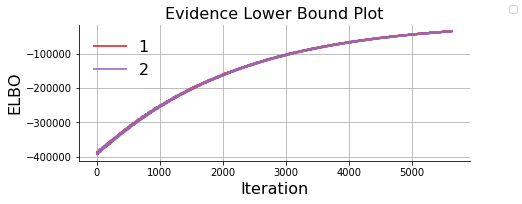

In [53]:
ax,_ = elboplot(al_results_active['elbo'],elbo_2=al_results_control['elbo']); 
ax.legend('active','control');

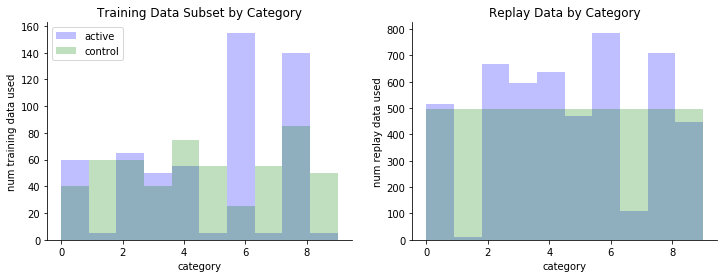

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

cat_used_active = [y_train[x.astype(int)] for x in al_results_active['ind_used']]
cat_used_active = [item for cat in cat_used_active for item in cat]
cat_used_control = [y_train[x.astype(int)] for x in al_results_control['ind_used']]
cat_used_control = [item for cat in cat_used_control for item in cat]

ax[0].hist(cat_used_active, bins=10, color='blue', alpha=.25, label='active')
ax[0].hist(cat_used_control, bins=10, color='green', alpha=.25, label='control')
ax[0].set_title('Training Data Subset by Category')
ax[0].set_xlabel('category')
ax[0].set_ylabel('num training data used')
ax[0].legend(); sns.despine();

ax[1].hist(y_train[al_results_active['replay_ind_used']], bins=10, color='blue', alpha=.25, label='active')
ax[1].hist(y_train[al_results_control['replay_ind_used']], bins=10, color='green', alpha=.25, label='control')
ax[1].set_title('Replay Data by Category')
ax[1].set_xlabel('category')
ax[1].set_ylabel('num replay data used');

Here we are plotting the number of training samples from each category that are used, and we can see that more samples are used from less certain categories, and more samples are replayed from uncertain categories.

### Assess test performance

In [55]:
# Prediction is mode of each
test_y_pred_active = sp.stats.mode(al_results_active['ppc_test']['out'], axis=0).mode[0,:]
test_y_pred_control = sp.stats.mode(al_results_control['ppc_test']['out'], axis=0).mode[0,:]

mean_test_perf = np.mean(test_y_pred_active==y_test)
print("Network Test Set Performance Active Learning: {:f}".format(mean_test_perf))
mean_test_perf = np.mean(test_y_pred_control==y_test)
print("Network Test Set Performance Control: {:f}".format(mean_test_perf))

Network Test Set Performance Active Learning: 0.608000
Network Test Set Performance Control: 0.570000


active error =  0.05166079004600001
control error =  0.054915887230000016


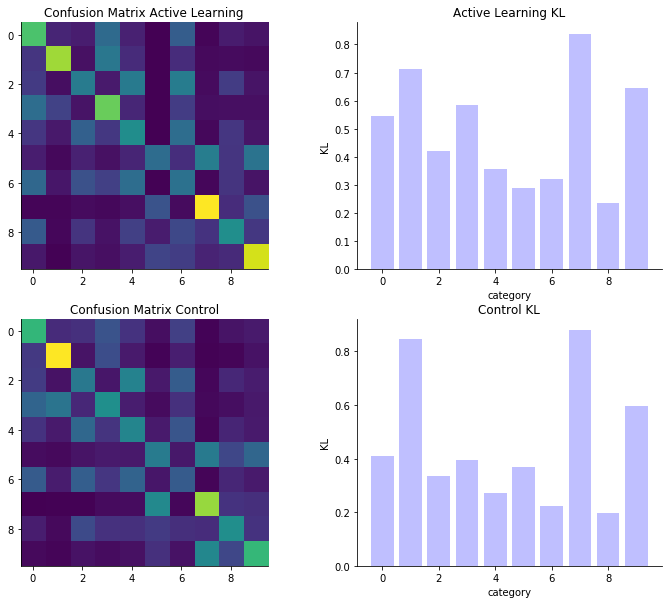

In [56]:
fig, ax = plt.subplots(2, 2, figsize=(12,10))

one_hot, cat_hist, cat_entropy, cat_KL = get_cat_entropy(X_test, y_test, al_results_active['ppc_test'])
act_diff_identity = np.sum((cat_hist/np.sum(cat_hist) - np.eye(10)/10)**2)
ax[0,0].imshow(cat_hist)
ax[0,0].set_title('Confusion Matrix Active Learning')

ax[0,1].bar(np.arange(10), cat_KL, color='blue', alpha=.25)
ax[0,1].set_xlabel('category')
ax[0,1].set_ylabel('KL')
ax[0,1].set_title('Active Learning KL')
sns.despine();

one_hot, cat_hist, cat_entropy, cat_KL = get_cat_entropy(X_test, y_test, al_results_control['ppc_test'])
cont_diff_identity = np.sum((cat_hist/np.sum(cat_hist) - np.eye(10)/10)**2)
ax[1,0].imshow(cat_hist)
ax[1,0].set_title('Confusion Matrix Control')
ax[1,1].bar(np.arange(10), cat_KL, color='blue', alpha=.25)
ax[1,1].set_xlabel('category')
ax[1,1].set_ylabel('KL')
ax[1,1].set_title('Control KL')
sns.despine();

print('active error = ', act_diff_identity)
print('control error = ', cont_diff_identity)

#### Conclusion from Active Learning Part 3

Looking at the evolution of the ELBO across iterations and comparing the test performance, we see almost no difference between the active learning dataset and the control network. The confusion matrices are also very similar, and the KL shows that the same categories are still most uncertain.

#### Active Learning Summary


Unfortunately, we don't see an effect of active learning with this example. Because the rise in performance to almost assymptotic performance happens very rapidly with increasing data, it might be hard to increase this speed further. If we comapre the confusion matrix after training on only 200 training points to the confusion matrix after training on all 60K training points, we can see that it is much better with all of the training data. However, this only raises the percent correct less than 10%. It could be that for this dataset the key in reducing that uncertainty lies in having MANY more training examples for each category, and that simply shifting the balance toward training on more uncertain categories at the beginning on learning is not enough. 

This is a relatively contrived example of using active learning, but it is a very useful concept. It is particularly useful when computation time is a limited resource relative to the data available. In this case it is very important to choose training data that will be most useful for improving performance. For example, in reinforcement learning type problems, an agent interacts witht the world in order to learn how to maximize its reward. Uncertainty can be used in this type of problem as a principled method for driving exploration. It is important for the agent to explore to avoid getting stuck in local minima, but once it is sufficiently certain about the environment it is better for the agent to reduce its exploration and increase its exploitation the strategy that it has found to be best. Usually this is done by reducing an expoloration parameter over time (e.g. epsilon in epsilon-greedy). However, this strategy does not target specific uncertain regions, and consequently does not